[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab11_rl.ipynb)

# Deep Reinforcement Learning

## Objective

- Build DQN and PPO Deep RL algorithms
- Learn the difference between Q Learning and Policy Gradient techniques

## Deliverable

For this lab you will submit an ipython notebook via learning suite. This lab gives you a lot of code, and you should only need to modify two of the cells of this notebook. Feel free to download and modify this notebook or create your own. The below code is given for your convinience. You can modify any of the given code if you wish.

## Tips

Deep reinforcement learning is difficult. We provide hyperparameters, visualizations, and code for gathering experience, but require you to code up algorithms for training your networks.

- Your networks should be able to demonstrate learning on cartpole within a minute of wall time.

- Understand what your the starter code is doing. This will help you with the *TODO* sections. The main code block is similar for the two algorithms with some small yet important differences.

- We provide hyperparameters for you to start with. Feel free to experiment with different values, but these worked for us.

- **Print dtypes and shapes** throughout your code to make sure your tensors look the way you expect.

- The DQN algorithm is significantly more unstable than PPO. Even with a correct implementation it may fail to learn every 1/10 times.

- Unfortunately visualizing your agent acting in the environment is non-trivial in Colab. You can visualize your agent by running this code locally and uncommenting the `env.render()` line.

## Grading

- 40% Part 1: DQN *TODO* methods
- 40% Part 2: PPO *TODO* methods
- 20% Cartpole learning curves


### Cartpole

Cartpole is a simple environment to get your agent up and running. It has a continuous state space of 4 dimensions and a discrete action space of 2. The agent is given a reward of 1 for each timestep it remains standing. Your agent should be able to reach close to 200 cumulative reward for an episode after a minute or two of training. The below graphs show example results for dqn (left) and ppo (right).

![alt text](https://github.com/wingated/cs474_labs/blob/master/images/dqn.png?raw=true)
![alt text](https://github.com/wingated/cs474_labs/blob/master/images/ppo.png?raw=true)

### TODO

- Train DQN and PPO on cartpole
- Display learning curves with average episodic reward per epoch

# Starter Code

## Init

In [1]:
! pip3 install gymnasium
! pip3 install torch
! pip install pygame
! pip install moviepy==1.0.3
! pip install imageio_ffmpeg
! pip install pyvirtualdisplay
! apt-get install -y xvfb python3-opengl ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 45.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 python3-opengl x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,639 kB of archives.
After this operation, 20.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.min_level = 40 # Error only

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

In [4]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

## DQN

## Part 1


Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

### TODO

- Implement get action method with e-greedy policy
- Implement sample batch method
- Implement DQN learning algorithm



In [9]:
from os import stat
def get_action_dqn(network, state, epsilon, epsilon_decay):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """
  if random.random() < epsilon:  # With p=epsilon, take a random action
      action = random.randint(0, 1)
      return action, epsilon*epsilon_decay
  else:  # With p=1-epsilon, take the action with the largest q-value
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      q_values = network(state)
      action = torch.argmax(q_values).item()
      return action, epsilon*epsilon_decay


def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  batch = random.sample(memory, batch_size)  # Randomly sample batch from memory
  state, action, next_state, reward, done = zip(*batch)  # Unpack batch
  # Convert to tensors of correct types and return
  state = torch.from_numpy(np.array(state)).float().to(device)
  action = torch.from_numpy(np.array(action)).long().to(device)
  next_state = torch.from_numpy(np.array(next_state)).float().to(device)
  reward = torch.from_numpy(np.array(reward)).float().to(device)
  done = torch.from_numpy(np.array(done)).float().to(device)
  return state, action, next_state, reward, done


def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  """
  state, action, next_state, reward, done = batch

  q_values = q_network(state)  # Get the q values for the current state
  q_value = torch.gather(q_values, 1, action.unsqueeze(1)).squeeze(1)  # Get the q_value for the action

  next_q_values = target_network(next_state).detach()   # Get the q values for the next state
  next_q_value = torch.max(next_q_values, 1)[0]  # Get the largest q value of next state

  expected_q_value = reward + gamma*next_q_value*(1 - done)   # The target Q-value (via Bellman)
  loss = torch.mean(torch.pow(q_value - expected_q_value, 2))   # Calculate the loss

  # Gradient descent step
  optim.zero_grad()
  loss.backward()
  optim.step()

  # Update target network every target_update global steps
  if global_step % target_update == 0:
      target_network.load_state_dict(q_network.state_dict())

### Modules

In [6]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))

  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

### Main

In [10]:
def dqn_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 500
  start_training = 1000
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  q_network = QNetwork(state_size, action_size).cuda()
  target_network = QNetwork(state_size, action_size).cuda()
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # Record the last epoch, not the previous epochs
    if last_epoch:
      env = wrap_env(env)

    # Reset environment
    state, _ = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < 200:  # End after 200 steps
      # Select e-greedy action
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)
      print(epsilon)

      # Take step
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      # env.render()

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)

        # Train
        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    env.close()
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

  return results_dqn

results_dqn = dqn_main()
show_video()

Episodes: 22 Reward: 17.0:   5%|▍         | 23/500 [00:00<00:04, 105.41it/s]

0.9999
0.9998000100000001
0.9997000299990001
0.9996000599960002
0.9995000999900007
0.9994001499800017
0.9993002099650037
0.9992002799440072
0.9991003599160128
0.9990004498800211
0.9989005498350332
0.9988006597800497
0.9987007797140718
0.9986009096361004
0.9985010495451367
0.9984011994401822
0.9983013593202382
0.9982015291843062
0.9981017090313877
0.9980018988604846
0.9979020986705985
0.9978023084607315
0.9977025282298854
0.9976027579770624
0.9975029977012647
0.9974032474014946
0.9973035070767544
0.9972037767260468
0.9971040563483742
0.9970043459427393
0.9969046455081451
0.9968049550435942
0.9967052745480899
0.9966056040206351
0.9965059434602331
0.9964062928658871
0.9963066522366005
0.9962070215713769
0.9961074008692198
0.9960077901291329
0.9959081893501199
0.995808598531185
0.9957090176713319
0.9956094467695648
0.9955098858248879
0.9954103348363054
0.9953107938028217
0.9952112627234414
0.9951117415971691
0.9950122304230093
0.9949127291999671
0.9948132379270471
0.9947137566032545
0.9946

Episodes: 35 Reward: 20.0:   7%|▋         | 36/500 [00:00<00:05, 90.63it/s]


0.9547532821708853
0.9546578068426682
0.9545623410619839
0.9544668848278777
0.9543714381393948
0.954276000995581
0.9541805733954815
0.9540851553381419
0.9539897468226081
0.9538943478479258
0.953798958413141
0.9537035785172997
0.953608208159448
0.9535128473386321
0.9534174960538983
0.9533221543042929
0.9532268220888624
0.9531314994066535
0.9530361862567129
0.9529408826380873
0.9528455885498235
0.9527503039909685
0.9526550289605694
0.9525597634576733
0.9524645074813276
0.9523692610305795
0.9522740241044765
0.9521787967020661
0.9520835788223959
0.9519883704645137
0.9518931716274672
0.9517979823103044
0.9517028025120734
0.9516076322318222
0.9515124714685991
0.9514173202214522
0.95132217848943
0.9512270462715811
0.9511319235669539
0.9510368103745972
0.9509417066935597
0.9508466125228904
0.9507515278616381
0.9506564527088519
0.9505613870635811
0.9504663309248748
0.9503712842917823
0.9502762471633531
0.9501812195386368
0.9500862014166829
0.9499911927965412
0.9498961936772615
0.94980120405789

Episodes: 46 Reward: 14.0:   9%|▉         | 47/500 [00:00<00:05, 77.52it/s]

0.9209918284199904
0.9208997292371484
0.9208076392642246
0.9207155585002982
0.9206234869444482
0.9205314245957538
0.9204393714532942
0.9203473275161489
0.9202552927833972
0.9201632672541189
0.9200712509273935
0.9199792438023008
0.9198872458779206
0.9197952571533328
0.9197032776276175
0.9196113072998547
0.9195193461691248
0.9194273942345079
0.9193354514950844
0.919243517949935
0.91915159359814
0.9190596784387802
0.9189677724709363
0.9188758756936892
0.9187839881061198
0.9186921097073092
0.9186002404963385
0.9185083804722889
0.9184165296342417
0.9183246879812783
0.9182328555124802
0.918141032226929
0.9180492181237063
0.917957413201894
0.9178656174605737
0.9177738308988277
0.9176820535157378
0.9175902853103862
0.9174985262818552
0.9174067764292271
0.9173150357515841
0.917223304248009
0.9171315819175843
0.9170398687593925
0.9169481647725165
0.9168564699560393
0.9167647843090437
0.9166731078306128
0.9165814405198298
0.9164897823757778
0.9163981333975403
0.9163064935842006
0.9162148629348421

Episodes: 50 Reward: 16.0:  10%|█         | 51/500 [00:00<00:05, 77.52it/s]

0.9016713562694217
0.9015811891337948
0.9014910310148815
0.90140088191178
0.9013107418235888
0.9012206107494065
0.9011304886883316
0.9010403756394627
0.9009502716018988
0.9008601765747386
0.9007700905570811
0.9006800135480254
0.9005899455466706
0.900499886552116
0.9004098365634607
0.9003197955798045
0.9002297636002465
0.9001397406238866
0.9000497266498242
0.8999597216771592
0.8998697257049915
0.899779738732421
0.8996897607585478
0.899599791782472
0.8995098318032937
0.8994198808201134
0.8993299388320314
0.8992400058381482
0.8991500818375644
0.8990601668293806
0.8989702608126977
0.8988803637866164
0.8987904757502377
0.8987005967026628
0.8986107266429926
0.8985208655703283
0.8984310134837713
0.8983411703824229
0.8982513362653847
0.8981615111317581
0.898071694980645
0.897981887811147
0.8978920896223659
0.8978023004134037
0.8977125201833623
0.897622748931344
0.8975329866564509
0.8974432333577852
0.8973534890344494
0.897263753685546
0.8971740273101775
0.8970843099074465
0.8969946014764557
0.

Episodes: 52 Reward: 23.0:  11%|█         | 54/500 [00:01<00:11, 38.21it/s]

0.8926991299914938
0.8926098600784946
0.8925205990924868
0.8924313470325775
0.8923421038978743
0.8922528696874845
0.8921636444005158
0.8920744280360757
0.8919852205932721
0.8918960220712128
0.8918068324690056
0.8917176517857587
0.8916284800205801
0.8915393171725781
0.8914501632408608
0.8913610182245367
0.8912718821227142
0.8911827549345019
0.8910936366590085
0.8910045272953426
0.8909154268426132
0.8908263352999289
0.8907372526663989
0.8906481789411322
0.8905591141232382
0.8904700582118259
0.8903810112060048
0.8902919731048842
0.8902029439075737
0.890113923613183
0.8900249122208217
0.8899359097295996
0.8898469161386267
0.8897579314470128
0.889668955653868
0.8895799887583027
0.8894910307594268
0.8894020816563509
0.8893131414481853
0.8892242101340405
0.8891352877130271
0.8890463741842558
0.8889574695468374
0.8888685737998827
0.8887796869425028
0.8886908089738085
0.8886019398929111
0.8885130796989219
0.888424228390952
0.8883353859681129
0.8882465524295161
0.8881577277742732
0.8880689120014

Episodes: 58 Reward: 21.0:  12%|█▏        | 59/500 [00:01<00:11, 38.21it/s]

0.8829327647263857
0.8828444714499131
0.8827561870027681
0.8826679113840679
0.8825796445929295
0.8824913866284702
0.8824031374898074
0.8823148971760584
0.8822266656863408
0.8821384430197722
0.8820502291754702
0.8819620241525526
0.8818738279501374
0.8817856405673423
0.8816974620032856
0.8816092922570853
0.8815211313278596
0.8814329792147269
0.8813448359168053
0.8812567014332137
0.8811685757630704
0.8810804589054941
0.8809923508596036
0.8809042516245177
0.8808161611993552
0.8807280795832353
0.880640006775277
0.8805519427745995
0.880463887580322
0.880375841191564
0.8802878036074449
0.8801997748270841
0.8801117548496015
0.8800237436741165
0.879935741299749
0.8798477477256191
0.8797597629508466
0.8796717869745515
0.8795838197958541
0.8794958614138745
0.8794079118277331
0.8793199710365504
0.8792320390394467
0.8791441158355427
0.8790562014239592
0.8789682958038169
0.8788803989742365
0.8787925109343391
0.8787046316832456
0.8786167612200774
0.8785288995439554
0.878441046654001
0.878353202549335

Episodes: 64 Reward: 15.0:  13%|█▎        | 65/500 [00:01<00:13, 33.41it/s]

0.8736226427309757
0.8735352804667026
0.8734479269386559
0.873360582145962
0.8732732460877475
0.8731859187631387
0.8730986001712624
0.8730112903112452
0.8729239891822141
0.8728366967832959
0.8727494131136175
0.8726621381723062
0.8725748719584889
0.8724876144712931
0.8724003657098459
0.8723131256732749
0.8722258943607076
0.8721386717712716
0.8720514579040944
0.871964252758304
0.8718770563330283
0.8717898686273949
0.8717026896405322
0.8716155193715681
0.871528357819631
0.871441204983849
0.8713540608633507
0.8712669254572644
0.8711797987647186
0.8710926807848421
0.8710055715167637
0.8709184709596121
0.8708313791125161
0.8707442959746048
0.8706572215450074
0.8705701558228529
0.8704830988072706
0.8703960504973899
0.8703090108923401
0.870221979991251
0.8701349577932518
0.8700479442974725
0.8699609395030428
0.8698739434090925
0.8697869560147516
0.8696999773191502
0.8696130073214182
0.8695260460206861
0.869439093416084
0.8693521495067424
0.8692652142917918
0.8691782877703627
0.8690913699415856

Episodes: 68 Reward: 17.0:  14%|█▍        | 69/500 [00:01<00:12, 33.41it/s]

0.8651025315568971
0.8650160213037414
0.864929519701611
0.8648430267496409
0.8647565424469659
0.8646700667927212
0.8645835997860419
0.8644971414260634
0.8644106917119208
0.8643242506427495
0.8642378182176853
0.8641513944358635
0.8640649792964199
0.8639785727984902
0.8638921749412104
0.8638057857237162
0.8637194051451439
0.8636330332046294
0.8635466699013089
0.8634603152343188
0.8633739692027953
0.863287631805875
0.8632013030426944
0.8631149829123901
0.8630286714140989
0.8629423685469575
0.8628560743101028
0.8627697887026718
0.8626835117238016
0.8625972433726292
0.8625109836482919
0.8624247325499271
0.8623384900766722
0.8622522562276645
0.8621660310020418
0.8620798143989417
0.8619936064175018
0.8619074070568601
0.8618212163161544
0.8617350341945228
0.8616488606911034
0.8615626958050343
0.8614765395354538
0.8613903918815002
0.861304252842312
0.8612181224170278
0.8611320006047861
0.8610458874047257
0.8609597828159852
0.8608736868377036
0.8607875994690198
0.8607015207090729
0.8606154505570

Episodes: 73 Reward: 17.0:  15%|█▍        | 74/500 [00:01<00:15, 28.18it/s]

0.8564941892681375
0.8564085398492106
0.8563228989952257
0.8562372667053262
0.8561516429786556
0.8560660278143578
0.8559804212115764
0.8558948231694552
0.8558092336871382
0.8557236527637695
0.8556380803984931
0.8555525165904533
0.8554669613387943
0.8553814146426604
0.8552958765011961
0.855210346913546
0.8551248258788546
0.8550393133962667
0.854953809464927
0.8548683140839806
0.8547828272525722
0.854697348969847
0.85461187923495
0.8545264180470264
0.8544409654052217
0.8543555213086812
0.8542700857565504
0.8541846587479748
0.8540992402820999
0.8540138303580718
0.853928428975036
0.8538430361321384
0.8537576518285253
0.8536722760633424
0.8535869088357361
0.8535015501448525
0.8534161999898381
0.8533308583698391
0.8532455252840021
0.8531602007314737
0.8530748847114006
0.8529895772229295
0.8529042782652072
0.8528189878373807
0.852733705938597
0.8526484325680032
0.8525631677247464
0.8524779114079739
0.8523926636168331
0.8523074243504714
0.8522221936080363
0.8521369713886755
0.8520517576915366


Episodes: 77 Reward: 40.0:  16%|█▌        | 78/500 [00:02<00:16, 25.67it/s]

0.8476323679505497
0.8475476047137547
0.8474628499532834
0.847378103668288
0.8472933658579213
0.8472086365213355
0.8471239156576834
0.8470392032661177
0.8469544993457911
0.8468698038958565
0.846785116915467
0.8467004384037754
0.846615768359935
0.8465311067830991
0.8464464536724208
0.8463618090270535
0.8462771728461508
0.8461925451288662
0.8461079258743534
0.8460233150817659
0.8459387127502577
0.8458541188789827
0.8457695334670947
0.845684956513748
0.8456003880180966
0.8455158279792948
0.8454312763964968
0.8453467332688572
0.8452621985955303
0.8451776723756708
0.8450931546084332
0.8450086452929724
0.8449241444284431
0.8448396520140002
0.8447551680487988
0.8446706925319939
0.8445862254627408
0.8445017668401945
0.8444173166635105
0.8443328749318442
0.844248441644351
0.8441640168001866
0.8440796003985066
0.8439951924384668
0.8439107929192229
0.843826401839931
0.843742019199747
0.843657644997827
0.8435732792333273
0.8434889219054039
0.8434045730132134
0.843320232555912
0.8432359005326565
0.

Episodes: 82 Reward: 13.0:  17%|█▋        | 83/500 [00:02<00:16, 24.91it/s]

0.8391978653428435
0.8391139455563091
0.8390300341617535
0.8389461311583373
0.8388622365452214
0.8387783503215669
0.8386944724865347
0.838610603039286
0.8385267419789821
0.8384428893047843
0.8383590450158538
0.8382752091113522
0.8381913815904412
0.8381075624522821
0.8380237516960369
0.8379399493208673
0.8378561553259353
0.8377723697104027
0.8376885924734316
0.8376048236141843
0.837521063131823
0.8374373110255098
0.8373535672944072
0.8372698319376778
0.837186104954484
0.8371023863439886
0.8370186761053542
0.8369349742377437
0.8368512807403199
0.8367675956122459
0.8366839188526847
0.8366002504607994
0.8365165904357533
0.8364329387767098
0.8363492954828321
0.8362656605532838
0.8361820339872285
0.8360984157838297
0.8360148059422513
0.8359312044616571
0.835847611341211
0.8357640265800769
0.8356804501774189
0.8355968821324011
0.8355133224441879
0.8354297711119435
0.8353462281348323
0.8352626935120188
0.8351791672426676
0.8350956493259434
0.8350121397610107
0.8349286385470347
0.83484514568318

Episodes: 87 Reward: 10.0:  18%|█▊        | 88/500 [00:02<00:17, 24.10it/s]

0.830847291613893
0.8307642068847316
0.8306811304640431
0.8305980623509968
0.8305150025447616
0.8304319510445072
0.8303489078494027
0.8302658729586178
0.8301828463713219
0.8300998280866848
0.8300168181038762
0.8299338164220658
0.8298508230404236
0.8297678379581195
0.8296848611743237
0.8296018926882063
0.8295189324989375
0.8294359806056876
0.829353037007627
0.8292701017039262
0.8291871746937558
0.8291042559762865
0.8290213455506888
0.8289384434161338
0.8288555495717922
0.828772664016835
0.8286897867504334
0.8286069177717583
0.8285240570799811
0.8284412046742732
0.8283583605538057
0.8282755247177503
0.8281926971652785
0.828109877895562
0.8280270669077725
0.8279442642010817
0.8278614697746616
0.8277786836276841
0.8276959057593214
0.8276131361687454
0.8275303748551286
0.8274476218176431
0.8273648770554614
0.8272821405677558
0.8271994123536991
0.8271166924124638
0.8270339807432225
0.8269512773451482
0.8268685822174137
0.8267858953591919
0.826703216769656
0.826620546447979
0.8265378843933342

Episodes: 90 Reward: 37.0:  18%|█▊        | 91/500 [00:02<00:16, 24.73it/s]

0.822908925814934
0.8228266349223525
0.8227443522588603
0.8226620778236344
0.822579811615852
0.8224975536346905
0.822415303879327
0.8223330623489391
0.8222508290427042
0.8221686039598
0.822086387099404
0.8220041784606941
0.8219219780428481
0.8218397858450438
0.8217576018664593
0.8216754261062726
0.821593258563662
0.8215110992378057
0.8214289481278819
0.8213468052330691
0.8212646705525458
0.8211825440854905
0.821100425831082
0.8210183157884989
0.8209362139569201
0.8208541203355244
0.8207720349234908
0.8206899577199985
0.8206078887242265
0.8205258279353541
0.8204437753525606
0.8203617309750254
0.8202796948019279
0.8201976668324477
0.8201156470657645
0.8200336355010579
0.8199516321375078
0.819869636974294
0.8197876500105966
0.8197056712455956
0.819623700678471
0.8195417383084032
0.8194597841345723
0.8193778381561588
0.8192959003723432
0.819213970782306
0.8191320493852278
0.8190501361802892
0.8189682311666712
0.8188863343435545
0.8188044457101201
0.8187225652655491
0.8186406930090225
0.818

Episodes: 96 Reward: 16.0:  19%|█▉        | 97/500 [00:02<00:17, 23.11it/s]

0.8150464074697662
0.8149649028290192
0.8148834063387363
0.8148019179981025
0.8147204378063028
0.8146389657625221
0.8145575018659459
0.8144760461157593
0.8143945985111477
0.8143131590512966
0.8142317277353915
0.814150304562618
0.8140688895321618
0.8139874826432086
0.8139060838949443
0.8138246932865548
0.8137433108172262
0.8136619364861445
0.8135805702924959
0.8134992122354666
0.8134178623142431
0.8133365205280116
0.8132551868759589
0.8131738613572713
0.8130925439711356
0.8130112347167385
0.8129299335932668
0.8128486405999075
0.8127673557358475
0.8126860790002739
0.8126048103923739
0.8125235499113347
0.8124422975563436
0.8123610533265879
0.8122798172212553
0.8121985892395331
0.8121173693806092
0.8120361576436711
0.8119549540279067
0.811873758532504
0.8117925711566507
0.811711391899535
0.8116302207603451
0.811549057738269
0.8114679028324951
0.8113867560422119
0.8113056173666077
0.811224486804871
0.8111433643561905
0.8110622500197548
0.8109811437947528
0.8109000456803733
0.810818955675805

Episodes: 100 Reward: 35.0:  20%|██        | 101/500 [00:03<00:16, 23.73it/s]

0.8067747775562383
0.8066941000784826
0.8066134306684748
0.806532769325408
0.8064521160484754
0.8063714708368706
0.8062908336897868
0.8062102046064179
0.8061295835859573
0.8060489706275987
0.805968365730536
0.805887768893963
0.8058071801170735
0.8057265993990619
0.805646026739122
0.8055654621364481
0.8054849055902344
0.8054043570996754
0.8053238166639655
0.8052432842822991
0.8051627599538709
0.8050822436778755
0.8050017354535077
0.8049212352799624
0.8048407431564344
0.8047602590821188
0.8046797830562106
0.8045993150779049
0.8045188551463972
0.8044384032608826
0.8043579594205564
0.8042775236246144
0.8041970958722519
0.8041166761626647
0.8040362644950484
0.8039558608685989
0.8038754652825121
0.8037950777359838
0.8037146982282102
0.8036343267583874
0.8035539633257116
0.803473607929379
0.8033932605685862
0.8033129212425293
0.803232589950405
0.80315226669141
0.8030719514647409
0.8029916442695944
0.8029113451051674
0.8028310539706569
0.8027507708652598
0.8026704957881733
0.8025902287385944
0

Episodes: 107 Reward: 14.0:  22%|██▏       | 108/500 [00:03<00:15, 25.44it/s]

0.7987468349924324
0.7986669603089331
0.7985870936129023
0.7985072349035409
0.7984273841800505
0.7983475414416326
0.7982677066874884
0.7981878799168196
0.7981080611288279
0.7980282503227151
0.7979484474976828
0.797868652652933
0.7977888657876677
0.797709086901089
0.797629315992399
0.7975495530607997
0.7974697981054936
0.7973900511256831
0.7973103121205705
0.7972305810893584
0.7971508580312495
0.7970711429454465
0.796991435831152
0.7969117366875689
0.7968320455139001
0.7967523623093486
0.7966726870731177
0.7965930198044103
0.7965133605024299
0.7964337091663797
0.7963540657954631
0.7962744303888836
0.7961948029458447
0.7961151834655501
0.7960355719472035
0.7959559683900088
0.7958763727931698
0.7957967851558905
0.7957172054773749
0.7956376337568272
0.7955580699934515
0.7954785141864521
0.7953989663350335
0.7953194264384
0.7952398944957562
0.7951603705063066
0.795080854469256
0.7950013463838091
0.7949218462491707
0.7948423540645458
0.7947628698291394
0.7946833935421564
0.7946039252028022
0

Episodes: 113 Reward: 21.0:  23%|██▎       | 114/500 [00:03<00:13, 28.28it/s]

0.7909569592483638
0.790877863552439
0.7907987757660838
0.7907196958885072
0.7906406239189183
0.7905615598565264
0.7904825037005407
0.7904034554501707
0.7903244151046257
0.7902453826631153
0.790166358124849
0.7900873414890366
0.7900083327548877
0.7899293319216122
0.78985033898842
0.7897713539545212
0.7896923768191259
0.7896134075814439
0.7895344462406858
0.7894554927960618
0.7893765472467822
0.7892976095920575
0.7892186798310983
0.7891397579631152
0.7890608439873189
0.7889819379029201
0.7889030397091299
0.788824149405159
0.7887452669902185
0.7886663924635195
0.7885875258242732
0.7885086670716908
0.7884298162049836
0.7883509732233631
0.7882721381260408
0.7881933109122282
0.788114491581137
0.7880356801319789
0.7879568765639657
0.7878780808763094
0.7877992930682217
0.7877205131389149
0.787641741087601
0.7875629769134922
0.7874842206158008
0.7874054721937392
0.7873267316465199
0.7872479989733553
0.787169274173458
0.7870905572460406
0.787011848190316
0.786933147005497
0.7868544536907964
0.7

Episodes: 119 Reward: 14.0:  24%|██▍       | 120/500 [00:03<00:13, 27.87it/s]

0.7836347942572791
0.7835564307778534
0.7834780751347756
0.7833997273272622
0.7833213873545294
0.783243055215794
0.7831647309102724
0.7830864144371814
0.7830081057957377
0.7829298049851581
0.7828515120046595
0.7827732268534591
0.7826949495307738
0.7826166800358207
0.7825384183678171
0.7824601645259803
0.7823819185095278
0.7823036803176768
0.782225449949645
0.78214722740465
0.7820690126819095
0.7819908057806414
0.7819126067000634
0.7818344154393934
0.7817562319978494
0.7816780563746496
0.7815998885690122
0.7815217285801553
0.7814435764072973
0.7813654320496566
0.7812872955064516
0.781209166776901
0.7811310458602233
0.7810529327556373
0.7809748274623617
0.7808967299796155
0.7808186403066175
0.7807405584425868
0.7806624843867426
0.7805844181383039
0.7805063596964901
0.7804283090605204
0.7803502662296143
0.7802722312029914
0.780194203979871
0.7801161845594731
0.7800381729410172
0.7799601691237231
0.7798821731068107
0.7798041848895001
0.7797262044710112
0.7796482318505641
0.7795702670273791

Episodes: 124 Reward: 24.0:  25%|██▌       | 125/500 [00:03<00:13, 27.56it/s]

0.7766133738209482
0.7765357124835661
0.7764580589123178
0.7763804131064266
0.7763027750651159
0.7762251447876094
0.7761475222731307
0.7760699075209033
0.7759923005301512
0.7759147013000982
0.7758371098299682
0.7757595261189852
0.7756819501663733
0.7756043819713567
0.7755268215331595
0.7754492688510063
0.7753717239241212
0.7752941867517288
0.7752166573330537
0.7751391356673204
0.7750616217537537
0.7749841155915783
0.7749066171800192
0.7748291265183012
0.7747516436056493
0.7746741684412888
0.7745967010244447
0.7745192413543422
0.7744417894302068
0.7743643452512637
0.7742869088167387
0.774209480125857
0.7741320591778444
0.7740546459719266
0.7739772405073294
0.7738998427832787
0.7738224527990004
0.7737450705537205
0.7736676960466652
0.7735903292770605
0.7735129702441328
0.7734356189471084
0.7733582753852137
0.7732809395576752
0.7732036114637194
0.773126291102573
0.7730489784734628
0.7729716735756155
0.7728943764082579
0.772817086970617
0.77273980526192
0.7726625312813938
0.772585265028265

Episodes: 129 Reward: 26.0:  26%|██▌       | 130/500 [00:04<00:14, 25.51it/s]

0.76927011530864
0.7691931882971091
0.7691162689782794
0.7690393573513816
0.7689624534156465
0.7688855571703049
0.768808668614588
0.7687317877477265
0.7686549145689517
0.7685780490774948
0.7685011912725871
0.7684243411534598
0.7683474987193445
0.7682706639694725
0.7681938369030756
0.7681170175193853
0.7680402058176334
0.7679634017970517
0.767886605456872
0.7678098167963263
0.7677330358146467
0.7676562625110652
0.7675794968848141
0.7675027389351257
0.7674259886612321
0.767349246062366
0.7672725111377597
0.767195783886646
0.7671190643082574
0.7670423524018266
0.7669656481665864
0.7668889516017697
0.7668122627066095
0.7667355814803388
0.7666589079221908
0.7665822420313986
0.7665055838071955
0.7664289332488148
0.7663522903554899
0.7662756551264543
0.7661990275609417
0.7661224076581856
0.7660457954174198
0.7659691908378781
0.7658925939187943
0.7658160046594024
0.7657394230589364
0.7656628491166305
0.7655862828317188
0.7655097242034357
0.7654331732310153
0.7653566299136922
0.7652800942507009

Episodes: 135 Reward: 15.0:  27%|██▋       | 136/500 [00:04<00:13, 27.42it/s]

0.7619200912607008
0.7618438992515748
0.7617677148616496
0.7616915380901634
0.7616153689363544
0.7615392073994608
0.7614630534787209
0.761386907173373
0.7613107684826557
0.7612346374058074
0.7611585139420669
0.7610823980906727
0.7610062898508636
0.7609301892218785
0.7608540962029563
0.760778010793336
0.7607019329922566
0.7606258627989574
0.7605498002126775
0.7604737452326562
0.7603976978581329
0.7603216580883472
0.7602456259225383
0.760169601359946
0.76009358439981
0.76001757504137
0.7599415732838659
0.7598655791265375
0.7597895925686249
0.7597136136093681
0.7596376422480071
0.7595616784837823
0.7594857223159339
0.7594097737437023
0.7593338327663279
0.7592578993830513
0.759181973593113
0.7591060553957537
0.7590301447902141
0.7589542417757351
0.7588783463515576
0.7588024585169224
0.7587265782710707
0.7586507056132437
0.7585748405426823
0.7584989830586281
0.7584231331603222
0.7583472908470061
0.7582714561179215
0.7581956289723096
0.7581198094094124
0.7580439974284714
0.7579681930287285
0

Episodes: 138 Reward: 19.0:  28%|██▊       | 139/500 [00:04<00:14, 24.90it/s]

0.7541122035729799
0.7540367923526227
0.7539613886733874
0.75388599253452
0.7538106039352666
0.753735222874873
0.7536598493525856
0.7535844833676503
0.7535091249193135
0.7534337740068217
0.753358430629421
0.753283094786358
0.7532077664768794
0.7531324457002317
0.7530571324556617
0.7529818267424162
0.7529065285597419
0.752831237906886
0.7527559547830953
0.752680679187617
0.7526054111196983
0.7525301505785863
0.7524548975635285
0.7523796520737721
0.7523044141085647
0.7522291836671539
0.7521539607487872
0.7520787453527122
0.7520035374781769
0.7519283371244291
0.7518531442907166
0.7517779589762875
0.7517027811803899
0.7516276109022719
0.7515524481411817
0.7514772928963676
0.7514021451670779
0.7513270049525612
0.751251872252066
0.7511767470648408
0.7511016293901344
0.7510265192271953
0.7509514165752726
0.7508763214336152
0.7508012338014718
0.7507261536780917
0.7506510810627239
0.7505760159546176
0.7505009583530222
0.7504259082571869
0.7503508656663612
0.7502758305797946
0.7502008029967366
0

Episodes: 141 Reward: 22.0:  28%|██▊       | 142/500 [00:04<00:17, 20.20it/s]

0.7484772378299342
0.7484023901061513
0.7483275498671407
0.748252717112154
0.7481778918404428
0.7481030740512588
0.7480282637438537
0.7479534609174793
0.7478786655713875
0.7478038777048304
0.7477290973170599
0.7476543244073283
0.7475795589748876
0.7475048010189901
0.7474300505388882
0.7473553075338344
0.7472805720030811
0.7472058439458807
0.7471311233614861
0.74705641024915
0.7469817046081252
0.7469070064376644
0.7468323157370206
0.7467576325054469
0.7466829567421964
0.7466082884465222
0.7465336276176775
0.7464589742549157
0.7463843283574902
0.7463096899246545
0.7462350589556621
0.7461604354497665
0.7460858194062215
0.7460112108242809
0.7459366097031985
0.7458620160422282
0.7457874298406241
0.7457128510976401
0.7456382798125303
0.7455637159845491
0.7454891596129506
0.7454146106969893
0.7453400692359197
0.7452655352289961
0.7451910086754732
0.7451164895746056
0.7450419779256482
0.7449674737278557
0.7448929769804828
0.7448184876827848
0.7447440058340166
0.7446695314334332
0.7445950644802

Episodes: 144 Reward: 15.0:  29%|██▉       | 145/500 [00:04<00:18, 19.68it/s]


0.7431072882334738
0.7430329775046505
0.7429586742069
0.7428843783394793
0.7428100899016453
0.7427358088926551
0.7426615353117658
0.7425872691582347
0.7425130104313189
0.7424387591302758
0.7423645152543628
0.7422902788028374
0.7422160497749571
0.7421418281699796
0.7420676139871627
0.741993407225764
0.7419192078850414
0.7418450159642529
0.7417708314626564
0.7416966543795102
0.7416224847140722
0.7415483224656008
0.7414741676333542
0.7414000202165908
0.7413258802145691
0.7412517476265477
0.741177622451785
0.7411035046895398
0.7410293943390709
0.740955291399637
0.7408811958704971
0.74080710775091
0.7407330270401349
0.7406589537374308
0.7405848878420571
0.740510829353273
0.7404367782703376
0.7403627345925106
0.7402886983190513
0.7402146694492194
0.7401406479822745
0.7400666339174763
0.7399926272540845
0.7399186279913591
0.73984463612856
0.7397706516649472
0.7396966745997806
0.7396227049323206
0.7395487426618274
0.7394747877875611
0.7394008403087824
0.7393269002247516
0.7392529675347291
0.7

Episodes: 148 Reward: 43.0:  30%|██▉       | 149/500 [00:05<00:19, 17.83it/s]

0.7370384213831916
0.7369647175410533
0.7368910210692992
0.7368173319671922
0.7367436502339956
0.7366699758689722
0.7365963088713853
0.7365226492404982
0.7364489969755741
0.7363753520758766
0.736301714540669
0.7362280843692149
0.736154461560778
0.736080846114622
0.7360072380300106
0.7359336373062075
0.735860043942477
0.7357864579380827
0.7357128792922889
0.7356393080043597
0.7355657440735593
0.735492187499152
0.7354186382804021
0.7353450964165741
0.7352715619069324
0.7351980347507417
0.7351245149472667
0.735051002495772
0.7349774973955224
0.7349039996457829
0.7348305092458184
0.7347570261948938
0.7346835504922743
0.7346100821372251
0.7345366211290114
0.7344631674668985
0.7343897211501519
0.7343162821780369
0.7342428505498191
0.7341694262647641
0.7340960093221377
0.7340225997212055
0.7339491974612334
0.7338758025414873
0.7338024149612332
0.733729034719737
0.7336556618162651
0.7335822962500834
0.7335089380204585
0.7334355871266565
0.7333622435679438
0.733288907343587
0.7332155784528527
0

Episodes: 153 Reward: 20.0:  31%|███       | 154/500 [00:05<00:16, 21.05it/s]

0.731019118230414
0.7309460163185909
0.7308729217169591
0.7307998344247874
0.7307267544413448
0.7306536817659007
0.7305806163977242
0.7305075583360844
0.7304345075802507
0.7303614641294928
0.7302884279830798
0.7302153991402816
0.7301423776003675
0.7300693633626074
0.7299963564262711
0.7299233567906285
0.7298503644549494
0.729777379418504
0.7297044016805622
0.7296314312403941
0.7295584680972701
0.7294855122504604
0.7294125636992354
0.7293396224428654
0.7292666884806212
0.7291937618117731
0.7291208424355919
0.7290479303513484
0.7289750255583133
0.7289021280557575
0.728829237842952
0.7287563549191677
0.7286834792836758
0.7286106109357474
0.7285377498746538
0.7284648960996664
0.7283920496100564
0.7283192104050954
0.7282463784840549
0.7281735538462065
0.728100736490822
0.7280279264171728
0.7279551236245312
0.7278823281121687
0.7278095398793575
0.7277367589253696
0.7276639852494771
0.7275912188509521
0.727518459729067
0.7274457078830942
0.7273729633123058
0.7273002260159747
0.727227495993373

Episodes: 159 Reward: 10.0:  32%|███▏      | 160/500 [00:05<00:14, 23.25it/s]

0.7251940055436178
0.7251214861430635
0.7250489739944492
0.7249764690970498
0.7249039714501402
0.7248314810529952
0.72475899790489
0.7246865220050994
0.724614053352899
0.7245415919475637
0.724469137788369
0.7243966908745901
0.7243242512055027
0.7242518187803821
0.7241793935985041
0.7241069756591443
0.7240345649615784
0.7239621615050822
0.7238897652889317
0.7238173763124028
0.7237449945747716
0.7236726200753141
0.7236002528133065
0.7235278927880252
0.7234555399987465
0.7233831944447466
0.7233108561253022
0.7232385250396897
0.7231662011871857
0.7230938845670669
0.7230215751786102
0.7229492730210924
0.7228769780937903
0.7228046903959808
0.7227324099269412
0.7226601366859485
0.7225878706722799
0.7225156118852127
0.7224433603240242
0.7223711159879919
0.7222988788763931
0.7222266489885055
0.7221544263236067
0.7220822108809744
0.7220100026598862
0.7219378016596203
0.7218656078794543
0.7217934213186664
0.7217212419765345
0.7216490698523369
0.7215769049453516
0.7215047472548571
0.72143259678013

Episodes: 163 Reward: 26.0:  33%|███▎      | 164/500 [00:05<00:16, 20.75it/s]

0.7201351213093324
0.7200631077972015
0.7199911014864218
0.7199191023762731
0.7198471104660354
0.7197751257549888
0.7197031482424133
0.7196311779275891
0.7195592148097963
0.7194872588883153
0.7194153101624265
0.7193433686314104
0.7192714342945472
0.7191995071511178
0.7191275872004027
0.7190556744416827
0.7189837688742385
0.7189118704973512
0.7188399793103014
0.7187680953123704
0.7186962185028392
0.7186243488809889
0.7185524864461008
0.7184806311974562
0.7184087831343364
0.718336942256023
0.7182651085617974
0.7181932820509412
0.7181214627227361
0.7180496505764639
0.7179778456114062
0.7179060478268451
0.7178342572220624
0.7177624737963402
0.7176906975489605
0.7176189284792056
0.7175471665863576
0.717475411869699
0.717403664328512
0.7173319239620791
0.717260190769683
0.7171884647506059
0.7171167459041309
0.7170450342295405
0.7169733297261175
0.7169016323931449
0.7168299422299056
0.7167582592356826
0.716686583409759
0.716614914751418
0.716543253259943
0.716471598934617
0.7163999517747235
0

Episodes: 168 Reward: 11.0:  34%|███▍      | 169/500 [00:05<00:14, 23.22it/s]

0.7141110217220364
0.7140396106198642
0.7139682066588022
0.7138968098381363
0.7138254201571524
0.7137540376151368
0.7136826622113753
0.7136112939451542
0.7135399328157597
0.713468578822478
0.7133972319645958
0.7133258922413993
0.7132545596521752
0.71318323419621
0.7131119158727903
0.713040604681203
0.7129693006207349
0.7128980036906729
0.7128267138903038
0.7127554312189148
0.7126841556757929
0.7126128872602253
0.7125416259714993
0.7124703718089022
0.7123991247717213
0.7123278848592441
0.7122566520707583
0.7121854264055512
0.7121142078629106
0.7120429964421243
0.7119717921424801
0.7119005949632659
0.7118294049037696
0.7117582219632792
0.7116870461410829
0.7116158774364688
0.7115447158487251
0.7114735613771402
0.7114024140210026
0.7113312737796005
0.7112601406522225
0.7111890146381573
0.7111178957366935
0.7110467839471198
0.7109756792687252
0.7109045817007983
0.7108334912426282
0.710762407893504
0.7106913316527146
0.7106202625195494
0.7105492004932974
0.7104781455732481
0.710407097758690

Episodes: 172 Reward: 31.0:  35%|███▍      | 173/500 [00:06<00:13, 24.23it/s]

0.7084206408979562
0.7083497988338664
0.708278963853983
0.7082081359575977
0.7081373151440019
0.7080665014124875
0.7079956947623463
0.70792489519287
0.7078541027033508
0.7077833172930805
0.7077125389613512
0.7076417677074551
0.7075710035306844
0.7075002464303313
0.7074294964056882
0.7073587534560476
0.707288017580702
0.707217288778944
0.7071465670500661
0.707075852393361
0.7070051448081217
0.7069344442936409
0.7068637508492116
0.7067930644741267
0.7067223851676793
0.7066517129291625
0.7065810477578696
0.7065103896530938
0.7064397386141285
0.7063690946402671
0.706298457730803
0.7062278278850299
0.7061572051022414
0.7060865893817312
0.706015980722793
0.7059453791247208
0.7058747845868083
0.7058041971083496
0.7057336166886388
0.7056630433269699
0.7055924770226373
0.705521917774935
0.7054513655831575
0.7053808204465991
0.7053102823645545
0.7052397513363181
0.7051692273611845
0.7050987104384484
0.7050282005674046
0.7049576977473478
0.7048872019775732
0.7048167132573754
0.7047462315860497
0.

Episodes: 175 Reward: 23.0:  35%|███▌      | 176/500 [00:06<00:17, 19.01it/s]

0.702775603771058
0.7027053262106808
0.7026350556780597
0.7025647921724919
0.7024945356932747
0.7024242862397053
0.7023540438110814
0.7022838084067002
0.7022135800258595
0.7021433586678569
0.7020731443319902
0.702002937017557
0.7019327367238553
0.7018625434501828
0.7017923571958379
0.7017221779601183
0.7016520057423222
0.701581840541748
0.7015116823576938
0.7014415311894581
0.7013713870363392
0.7013012498976355
0.7012311197726457
0.7011609966606684
0.7010908805610024
0.7010207714729464
0.7009506693957991
0.7008805743288595
0.7008104862714266
0.7007404052227995
0.7006703311822772
0.700600264149159
0.7005302041227441
0.7004601511023318
0.7003901050872217
0.7003200660767129
0.7002500340701052
0.7001800090666982
0.7001099910657915
0.700039980066685
0.6999699760686784
0.6998999790710715
0.6998299890731644
0.6997600060742571
0.6996900300736497
0.6996200610706423
0.6995500990645352
0.6994801440546288
0.6994101960402234
0.6993402550206194
0.6992703209951173
0.6992003939630178
0.699130473923621

Episodes: 178 Reward: 37.0:  36%|███▌      | 179/500 [00:06<00:16, 19.48it/s]

0.6974544889720155
0.6973847435231183
0.697315005048766
0.6972452735482612
0.6971755490209064
0.6971058314660044
0.6970361208828577
0.6969664172707695
0.6968967206290424
0.6968270309569795
0.6967573482538838
0.6966876725190584
0.6966180037518065
0.6965483419514313
0.6964786871172362
0.6964090392485245
0.6963393983445997
0.6962697644047652
0.6962001374283248
0.696130517414582
0.6960609043628405
0.6959912982724042
0.6959216991425771
0.6958521069726629
0.6957825217619656
0.6957129435097894
0.6956433722154385
0.695573807878217
0.6955042504974291
0.6954347000723794
0.6953651566023722
0.695295620086712
0.6952260905247033
0.6951565679156508
0.6950870522588593
0.6950175435536333
0.6949480417992779
0.694878546995098
0.6948090591403985
0.6947395782344844
0.694670104276661
0.6946006372662333
0.6945311772025067
0.6944617240847865
0.694392277912378
0.6943228386845868
0.6942534064007183
0.6941839810600783
0.6941145626619722
0.6940451512057061
0.6939757466905855
0.6939063491159164
0.6938369584810048


Episodes: 182 Reward: 17.0:  37%|███▋      | 183/500 [00:06<00:18, 17.35it/s]

0.6921736633670672
0.6921044460007305
0.6920352355561304
0.6919660320325749
0.6918968354293716
0.6918276457458287
0.6917584629812541
0.691689287134956
0.6916201182062426
0.691550956194422
0.6914818010988025
0.6914126529186927
0.6913435116534008
0.6912743773022355
0.6912052498645053
0.6911361293395188
0.6910670157265849
0.6909979090250122
0.6909288092341097
0.6908597163531863
0.690790630381551
0.6907215513185129
0.690652479163381
0.6905834139154647
0.6905143555740731
0.6904453041385158
0.6903762596081019
0.6903072219821411
0.6902381912599429
0.6901691674408169
0.6901001505240728
0.6900311405090204
0.6899621373949695
0.68989314118123
0.6898241518671119
0.6897551694519252
0.68968619393498
0.6896172253155864
0.6895482635930549
0.6894793087666956
0.689410360835819
0.6893414197997354
0.6892724856577555
0.6892035584091897
0.6891346380533487
0.6890657245895434
0.6889968180170845
0.6889279183352828
0.6888590255434492
0.6887901396408949
0.6887212606269307
0.6886523885008681
0.688583523262018
0.6

Episodes: 186 Reward: 10.0:  37%|███▋      | 187/500 [00:06<00:17, 18.16it/s]

0.6873451258912638
0.6872763913786747
0.6872076637395368
0.6871389429731628
0.6870702290788655
0.6870015220559577
0.686932821903752
0.6868641286215617
0.6867954422086995
0.6867267626644786
0.6866580899882122
0.6865894241792134
0.6865207652367955
0.6864521131602719
0.6863834679489559
0.686314829602161
0.6862461981192007
0.6861775734993888
0.6861089557420389
0.6860403448464647
0.6859717408119801
0.685903143637899
0.6858345533235352
0.6857659698682028
0.685697393271216
0.6856288235318889
0.6855602606495358
0.6854917046234709
0.6854231554530086
0.6853546131374633
0.6852860776761496
0.685217549068382
0.6851490273134752
0.6850805124107439
0.6850120043595028
0.6849435031590669
0.6848750088087511
0.6848065213078702
0.6847380406557394
0.6846695668516738
0.6846010998949886
0.6845326397849991
0.6844641865210206
0.6843957401023685
0.6843273005283582
0.6842588677983054
0.6841904419115256
0.6841220228673344
0.6840536106650477
0.6839852053039812
0.6839168067834508
0.6838484151027725
0.683780030261262

Episodes: 190 Reward: 26.0:  38%|███▊      | 191/500 [00:07<00:15, 20.30it/s]

0.6825502718324828
0.6824820168052996
0.6824137686036191
0.6823455272267588
0.6822772926740361
0.6822090649447687
0.6821408440382742
0.6820726299538704
0.682004422690875
0.681936222248606
0.6818680286263811
0.6817998418235185
0.6817316618393362
0.6816634886731523
0.681595322324285
0.6815271627920526
0.6814590100757734
0.6813908641747658
0.6813227250883483
0.6812545928158396
0.681186467356558
0.6811183487098224
0.6810502368749514
0.6809821318512639
0.6809140336380788
0.680845942234715
0.6807778576404915
0.6807097798547275
0.680641708876742
0.6805736447058544
0.6805055873413838
0.6804375367826496
0.6803694930289713
0.6803014560796684
0.6802334259340604
0.6801654025914671
0.680097386051208
0.6800293763126029
0.6799613733749716
0.6798933772376341
0.6798253878999103
0.6797574053611203
0.6796894296205842
0.6796214606776222
0.6795534985315544
0.6794855431817013
0.6794175946273832
0.6793496528679204
0.6792817179026336
0.6792137897308433
0.6791458683518703
0.6790779537650351
0.6790100459696586


Episodes: 195 Reward: 12.0:  39%|███▉      | 196/500 [00:07<00:14, 21.17it/s]

0.6769082691738516
0.6768405783469342
0.6767728942890996
0.6767052169996707
0.6766375464779707
0.6765698827233229
0.6765022257350505
0.676434575512477
0.6763669320549257
0.6762992953617202
0.676231665432184
0.6761640422656409
0.6760964258614143
0.6760288162188282
0.6759612133372063
0.6758936172158726
0.675826027854151
0.6757584452513656
0.6756908694068405
0.6756233003198998
0.6755557379898678
0.6754881824160688
0.6754206335978272
0.6753530915344674
0.6752855562253139
0.6752180276696914
0.6751505058669245
0.6750829908163378
0.6750154825172562
0.6749479809690044
0.6748804861709076
0.6748129981222905
0.6747455168224782
0.674678042270796
0.6746105744665689
0.6745431134091222
0.6744756590977813
0.6744082115318715
0.6743407707107183
0.6742733366336472
0.6742059092999838
0.6741384887090538
0.6740710748601829
0.6740036677526969
0.6739362673859217
0.6738688737591831
0.6738014868718072
0.6737341067231201
0.6736667333124478
0.6735993666391165
0.6735320067024525
0.6734646535017823
0.67339730703643

Episodes: 199 Reward: 39.0:  40%|████      | 200/500 [00:07<00:12, 23.27it/s]

0.6717158324128003
0.671648660829559
0.671581495963476
0.6715143378138797
0.6714471863800984
0.6713800416614604
0.6713129036572942
0.6712457723669285
0.6711786477896918
0.6711115299249129
0.6710444187719203
0.6709773143300432
0.6709102165986102
0.6708431255769504
0.6707760412643927
0.6707089636602663
0.6706418927639003
0.6705748285746239
0.6705077710917665
0.6704407203146573
0.6703736762426258
0.6703066388750015
0.6702396082111141
0.6701725842502929
0.6701055669918679
0.6700385564351686
0.6699715525795251
0.6699045554242672
0.6698375649687248
0.669770581212228
0.6697036041541068
0.6696366337936914
0.6695696701303121
0.6695027131632991
0.6694357628919828
0.6693688193156936
0.669301882433762
0.6692349522455187
0.6691680287502941
0.6691011119474191
0.6690342018362243
0.6689672984160407
0.6689004016861991
0.6688335116460306
0.668766628294866
0.6686997516320365
0.6686328816568734
0.6685660183687078
0.6684991617668709
0.6684323118506942
0.6683654686195091
0.6682986320726472
0.668231802209439

Episodes: 204 Reward: 13.0:  41%|████      | 205/500 [00:07<00:13, 22.10it/s]

0.6667632348314538
0.6666965585079707
0.6666298888521199
0.6665632258632347
0.6664965695406484
0.6664299198836944
0.666363276891706
0.6662966405640168
0.6662300108999605
0.6661633878988705
0.6660967715600806
0.6660301618829246
0.6659635588667363
0.6658969625108496
0.6658303728145986
0.6657637897773171
0.6656972133983393
0.6656306436769995
0.6655640806126318
0.6654975242045705
0.66543097445215
0.6653644313547048
0.6652978949115693
0.6652313651220781
0.6651648419855659
0.6650983255013674
0.6650318156688173
0.6649653124872504
0.6648988159560018
0.6648323260744061
0.6647658428417987
0.6646993662575146
0.6646328963208888
0.6645664330312567
0.6644999763879537
0.6644335263903148
0.6643670830376758
0.664300646329372
0.6642342162647391
0.6641677928431127
0.6641013760638284
0.664034965926222
0.6639685624296294
0.6639021655733864
0.6638357753568291
0.6637693917792935
0.6637030148401156
0.6636366445386316
0.6635702808741777
0.6635039238460902
0.6634375734537057
0.6633712296963603
0.663304892573390

Episodes: 208 Reward: 17.0:  42%|████▏     | 209/500 [00:07<00:14, 19.97it/s]

0.6618471530230265
0.6617809683077243
0.6617147902108935
0.6616486187318724
0.6615824538699993
0.6615162956246122
0.6614501439950498
0.6613839989806503
0.6613178605807521
0.6612517287946941
0.6611856036218146
0.6611194850614523
0.6610533731129462
0.6609872677756349
0.6609211690488573
0.6608550769319524
0.6607889914242593
0.6607229125251168
0.6606568402338643
0.6605907745498409
0.660524715472386
0.6604586630008388
0.6603926171345387
0.6603265778728252
0.660260545215038
0.6601945191605164
0.6601284997086003
0.6600624868586294
0.6599964806099436
0.6599304809618827
0.6598644879137865
0.6597985014649951
0.6597325216148486
0.6596665483626871
0.6596005817078509
0.65953462164968
0.659468668187515
0.6594027213206963
0.6593367810485643
0.6592708473704595
0.6592049202857224
0.6591389997936938
0.6590730858937145
0.6590071785851251
0.6589412778672666
0.65887538373948
0.6588094962011061
0.658743615251486
0.6586777408899608
0.6586118731158718
0.6585460119285602
0.6584801573273674
0.6584143093116347
0

Episodes: 213 Reward: 15.0:  43%|████▎     | 214/500 [00:08<00:13, 21.42it/s]

0.655457953888298
0.6553924080929091
0.6553268688520998
0.6552613361652145
0.655195810031598
0.6551302904505948
0.6550647774215498
0.6549992709438076
0.6549337710167132
0.6548682776396115
0.6548027908118476
0.6547373105327664
0.6546718368017131
0.654606369618033
0.6545409089810712
0.6544754548901731
0.6544100073446841
0.6543445663439497
0.6542791318873152
0.6542137039741265
0.654148282603729
0.6540828677754686
0.654017459488691
0.6539520577427422
0.6538866625369679
0.6538212738707142
0.6537558917433272
0.6536905161541529
0.6536251471025375
0.6535597845878273
0.6534944286093685
0.6534290791665075
0.6533637362585909
0.6532983998849651
0.6532330700449765
0.6531677467379721
0.6531024299632983
0.653037119720302
0.65297181600833
0.6529065188267291
0.6528412281748465
0.652775944052029
0.6527106664576238
0.652645395390978
0.6525801308514388
0.6525148728383537
0.6524496213510699
0.6523843763889348
0.6523191379512959
0.6522539060375008
0.6521886806468971
0.6521234617788324
0.6520582494326546
0.6

Episodes: 217 Reward: 12.0:  44%|████▎     | 218/500 [00:08<00:12, 23.05it/s]

0.6495200480576949
0.6494550960528892
0.649390150543284
0.6493252115282296
0.6492602790070768
0.6491953529791762
0.6491304334438783
0.649065520400534
0.649000613848494
0.6489357137871091
0.6488708202157304
0.6488059331337088
0.6487410525403955
0.6486761784351415
0.648611310817298
0.6485464496862162
0.6484815950412476
0.6484167468817434
0.6483519052070553
0.6482870700165346
0.648222241309533
0.648157419085402
0.6480926033434935
0.6480277940831591
0.6479629913037508
0.6478981950046204
0.64783340518512
0.6477686218446015
0.6477038449824171
0.6476390745979188
0.647574310690459
0.64750955325939
0.647444802304064
0.6473800578238336
0.6473153198180512
0.6472505882860694
0.6471858632272408
0.6471211446409181
0.647056432526454
0.6469917268832013
0.6469270277105129
0.6468623350077418
0.6467976487742411
0.6467329690093636
0.6466682957124626
0.6466036288828914
0.646538968520003
0.6464743146231511
0.6464096671916888
0.6463450262249696
0.6462803917223471
0.6462157636831749
0.6461511421068066
0.64608

Episodes: 220 Reward: 50.0:  44%|████▍     | 221/500 [00:08<00:12, 21.71it/s]

0.6435715711392158
0.6435072139821019
0.6434428632607037
0.6433785189743776
0.6433141811224802
0.6432498497043679
0.6431855247193975
0.6431212061669256
0.643056894046309
0.6429925883569043
0.6429282890980687
0.6428639962691588
0.6427997098695319
0.642735429898545
0.6426711563555552
0.6426068892399196
0.6425426285509956
0.6424783742881406
0.6424141264507118
0.6423498850380668
0.642285650049563
0.642221421484558
0.6421571993424096
0.6420929836224754
0.6420287743241131
0.6419645714466807
0.6419003749895361
0.6418361849520372
0.641772001333542
0.6417078241334087
0.6416436533509953
0.6415794889856602
0.6415153310367616
0.6414511795036579
0.6413870343857075
0.641322895682269
0.6412587633927007
0.6411946375163614
0.6411305180526098
0.6410664050008046
0.6410022983603045
0.6409381981304685
0.6408741043106554
0.6408100169002243
0.6407459358985343
0.6406818613049445
0.6406177931188141
0.6405537313395022
0.6404896759663683
0.6404256269987717
0.6403615844360718
0.6402975482776282
0.6402335185228004

Episodes: 224 Reward: 17.0:  45%|████▌     | 225/500 [00:08<00:14, 18.96it/s]

0.6379327067597865
0.6378689134891106
0.6378051265977617
0.6377413460851019
0.6376775719504935
0.6376138041932984
0.6375500428128791
0.6374862878085978
0.637422539179817
0.637358796925899
0.6372950610462065
0.6372313315401019
0.637167608406948
0.6371038916461073
0.6370401812569426
0.6369764772388169
0.636912779591093
0.6368490883131339
0.6367854034043026
0.6367217248639622
0.6366580526914758
0.6365943868862066
0.636530727447518
0.6364670743747733
0.6364034276673358
0.6363397873245691
0.6362761533458366
0.636212525730502
0.6361489044779289
0.6360852895874811
0.6360216810585224
0.6359580788904166
0.6358944830825275
0.6358308936342193
0.6357673105448559
0.6357037338138014
0.6356401634404201
0.6355765994240761
0.6355130417641337
0.6354494904599572
0.6353859455109112
0.6353224069163601
0.6352588746756684
0.6351953487882008
0.635131829253322
0.6350683160703967
0.6350048092387897
0.6349413087578658
0.63487781462699
0.6348143268455273
0.6347508454128428
0.6346873703283015
0.6346239015912687
0.

Episodes: 229 Reward: 11.0:  46%|████▌     | 230/500 [00:08<00:14, 19.08it/s]

0.6323432491486414
0.6322800148237265
0.6322167868222441
0.6321535651435619
0.6320903497870476
0.6320271407520689
0.6319639380379937
0.6319007416441899
0.6318375515700254
0.6317743678148684
0.6317111903780869
0.6316480192590491
0.6315848544571232
0.6315216959716775
0.6314585438020803
0.6313953979477002
0.6313322584079054
0.6312691251820646
0.6312059982695464
0.6311428776697194
0.6310797633819525
0.6310166554056142
0.6309535537400737
0.6308904583846997
0.6308273693388612
0.6307642866019273
0.6307012101732671
0.6306381400522497
0.6305750762382445
0.6305120187306207
0.6304489675287476
0.6303859226319947
0.6303228840397315
0.6302598517513275
0.6301968257661523
0.6301338060835757
0.6300707927029674
0.6300077856236971
0.6299447848451347
0.6298817903666503
0.6298188021876137
0.6297558203073949
0.6296928447253641
0.6296298754408916
0.6295669124533475
0.6295039557621022
0.6294410053665259
0.6293780612659893
0.6293151234598627
0.6292521919475168
0.6291892667283221
0.6291263478016492
0.6290634351

Episodes: 234 Reward: 11.0:  47%|████▋     | 235/500 [00:09<00:11, 22.46it/s]

0.6259258117029464
0.6258632191217761
0.625800632799864
0.625738052736584
0.6256754789313104
0.6256129113834172
0.6255503500922789
0.6254877950572697
0.625425246277764
0.6253627037531362
0.6253001674827608
0.6252376374660126
0.625175113702266
0.6251125961908958
0.6250500849312767
0.6249875799227835
0.6249250811647913
0.6248625886566748
0.6248001023978091
0.6247376223875694
0.6246751486253306
0.6246126811104681
0.624550219842357
0.6244877648203728
0.6244253160438908
0.6243628735122865
0.6243004372249352
0.6242380071812127
0.6241755833804946
0.6241131658221566
0.6240507545055743
0.6239883494301238
0.6239259505951809
0.6238635580001214
0.6238011716443214
0.6237387915271569
0.6236764176480042
0.6236140500062394
0.6235516886012388
0.6234893334323787
0.6234269844990354
0.6233646418005856
0.6233023053364055
0.6232399751058719
0.6231776511083613
0.6231153333432505
0.6230530218099162
0.6229907165077352
0.6229284174360844
0.6228661245943408
0.6228038379818813
0.6227415575980831
0.622679283442323

Episodes: 239 Reward: 20.0:  48%|████▊     | 240/500 [00:09<00:11, 21.89it/s]

0.6200693845791024
0.6200073776406445
0.6199453769028804
0.6198833823651901
0.6198213940269536
0.6197594118875509
0.6196974359463622
0.6196354662027675
0.6195735026561473
0.6195115453058817
0.6194495941513511
0.619387649191936
0.6193257104270168
0.6192637778559741
0.6192018514781885
0.6191399312930407
0.6190780172999114
0.6190161094981814
0.6189542078872317
0.6188923124664429
0.6188304232351963
0.6187685401928729
0.6187066633388536
0.6186447926725197
0.6185829281932524
0.6185210699004331
0.618459217793443
0.6183973718716637
0.6183355321344765
0.618273698581263
0.6182118712114049
0.6181500500242837
0.6180882350192812
0.6180264261957793
0.6179646235531597
0.6179028270908045
0.6178410368080954
0.6177792527044146
0.6177174747791442
0.6176557030316663
0.6175939374613632
0.6175321780676171
0.6174704248498103
0.6174086778073253
0.6173469369395446
0.6172852022458506
0.617223473725626
0.6171617513782535
0.6171000352031156
0.6170383251995953
0.6169766213670754
0.6169149237049387
0.61685323221256

Episodes: 242 Reward: 14.0:  49%|████▊     | 243/500 [00:09<00:13, 19.05it/s]

0.6140220824215697
0.6139606802133276
0.6138992841453063
0.6138378942168917
0.6137765104274701
0.6137151327764273
0.6136537612631496
0.6135923958870233
0.6135310366474346
0.6134696835437699
0.6134083365754155
0.613346995741758
0.6132856610421838
0.6132243324760797
0.613163010042832
0.6131016937418278
0.6130403835724536
0.6129790795340964
0.612917781626143
0.6128564898479804
0.6127952041989956
0.6127339246785757
0.6126726512861078
0.6126113840209793
0.6125501228825772
0.6124888678702889
0.6124276189835018
0.6123663762216035
0.6123051395839814
0.612243909070023
0.6121826846791161
0.6121214664106481
0.6120602542640071
0.6119990482385808
0.6119378483337569
0.6118766545489235
0.6118154668834686
0.6117542853367802
0.6116931099082465
0.6116319405972557
0.611570777403196
0.6115096203254556
0.6114484693634231
0.6113873245164868
0.6113261857840352
0.6112650531654568
0.6112039266601402
0.6111428062674742
0.6110816919868475
0.6110205838176488
0.6109594817592671
0.6108983858110911
0.61083729597251


Episodes: 247 Reward: 16.0:  50%|████▉     | 248/500 [00:09<00:12, 20.23it/s]

0.6088856433508286
0.6088247547864936
0.6087638723110149
0.6087029959237839
0.6086421256241915
0.608581261411629
0.6085204032854878
0.6084595512451593
0.6083987052900348
0.6083378654195059
0.6082770316329639
0.6082162039298006
0.6081553823094076
0.6080945667711767
0.6080337573144996
0.6079729539387682
0.6079121566433743
0.6078513654277099
0.6077905802911672
0.607729801233138
0.6076690282530147
0.6076082613501894
0.6075475005240544
0.607486745774002
0.6074259970994246
0.6073652544997147
0.6073045179742648
0.6072437875224673
0.6071830631437151
0.6071223448374007
0.6070616326029169
0.6070009264396566
0.6069402263470127
0.6068795323243781
0.6068188443711456
0.6067581624867086
0.6066974866704599
0.6066368169217928
0.6065761532401006
0.6065154956247766
0.6064548440752141
0.6063941985908066
0.6063335591709474
0.6062729258150303
0.6062122985224488
0.6061516772925966
0.6060910621248673
0.6060304530186548
0.6059698499733529
0.6059092529883556
0.6058486620630568
0.6057880771968505
0.6057274983891

Episodes: 253 Reward: 11.0:  51%|█████     | 254/500 [00:10<00:10, 22.91it/s]

0.6030680195643146
0.6030077127623581
0.6029474119910818
0.6028871172498828
0.6028268285381577
0.6027665458553039
0.6027062692007183
0.6026459985737983
0.6025857339739409
0.6025254754005435
0.6024652228530034
0.6024049763307181
0.602344735833085
0.6022845013595017
0.6022242729093658
0.6021640504820748
0.6021038340770266
0.602043623693619
0.6019834193312497
0.6019232209893165
0.6018630286672175
0.6018028423643508
0.6017426620801144
0.6016824878139064
0.601622319565125
0.6015621573331685
0.6015020011174352
0.6014418509173235
0.6013817067322318
0.6013215685615586
0.6012614364047024
0.6012013102610619
0.6011411901300359
0.6010810760110229
0.6010209679034219
0.6009608658066316
0.6009007697200509
0.6008406796430789
0.6007805955751145
0.600720517515557
0.6006604454638055
0.6006003794192591
0.6005403193813172
0.6004802653493791
0.6004202173228442
0.600360175301112
0.6003001392835818
0.6002401092696534
0.6001800852587265
0.6001200672502006
0.6000600552434756
0.6000000492379512
0.599940049233027

Episodes: 258 Reward: 10.0:  52%|█████▏    | 259/500 [00:10<00:10, 23.09it/s]

0.5975449626465508
0.5974852081502862
0.5974254596294711
0.5973657170835082
0.5973059805117998
0.5972462499137486
0.5971865252887573
0.5971268066362284
0.5970670939555648
0.5970073872461692
0.5969476865074446
0.5968879917387938
0.59682830293962
0.596768620109326
0.596708943247315
0.5966492723529904
0.5965896074257551
0.5965299484650125
0.5964702954701661
0.5964106484406191
0.5963510073757751
0.5962913722750375
0.59623174313781
0.5961721199634963
0.5961125027515
0.5960528915012249
0.5959932862120747
0.5959336868834535
0.5958740935147652
0.5958145061054136
0.5957549246548031
0.5956953491623376
0.5956357796274213
0.5955762160494585
0.5955166584278536
0.5954571067620108
0.5953975610513346
0.5953380212952294
0.5952784874930999
0.5952189596443506
0.5951594377483861
0.5950999218046112
0.5950404118124308
0.5949809077712496
0.5949214096804725
0.5948619175395045
0.5948024313477505
0.5947429511046157
0.5946834768095053
0.5946240084618244
0.5945645460609782
0.594505089606372
0.5944456390974114
0.5

Episodes: 262 Reward: 24.0:  53%|█████▎    | 263/500 [00:10<00:10, 22.34it/s]

0.5917173326559357
0.5916581609226701
0.5915989951065779
0.5915398352070672
0.5914806812235465
0.5914215331554241
0.5913623910021086
0.5913032547630084
0.591244124437532
0.5911850000250883
0.5911258815250858
0.5910667689369333
0.5910076622600396
0.5909485614938137
0.5908894666376643
0.5908303776910006
0.5907712946532314
0.5907122175237661
0.5906531463020137
0.5905940809873835
0.5905350215792848
0.5904759680771269
0.5904169204803191
0.5903578787882711
0.5902988430003923
0.5902398131160922
0.5901807891347806
0.590121771055867
0.5900627588787615
0.5900037526028736
0.5899447522276133
0.5898857577523906
0.5898267691766154
0.5897677864996977
0.5897088097210478
0.5896498388400757
0.5895908738561917
0.5895319147688061
0.5894729615773292
0.5894140142811715
0.5893550728797433
0.5892961373724553
0.5892372077587181
0.5891782840379423
0.5891193662095384
0.5890604542729174
0.5890015482274902
0.5889426480726674
0.5888837538078602
0.5888248654324794
0.5887659829459361
0.5887071063476415
0.588648235637

Episodes: 264 Reward: 42.0:  53%|█████▎    | 265/500 [00:10<00:10, 22.34it/s]

0.5867674780606377
0.5867088013128317
0.5866501304327004
0.5865914654196571
0.5865328062731152
0.586474152992488
0.5864155055771887
0.586356864026631
0.5862982283402284
0.5862395985173944
0.5861809745575427
0.5861223564600869
0.586063744224441
0.5860051378500185
0.5859465373362335
0.5858879426824999
0.5858293538882317
0.5857707709528428
0.5857121938757476
0.58565362265636
0.5855950572940943
0.5855364977883649
0.5854779441385861
0.5854193963441723
0.5853608544045379
0.5853023183190974
0.5852437880872655
0.5851852637084568
0.585126745182086
0.5850682325075678
0.5850097256843171
0.5849512247117487
0.5848927295892775
0.5848342403163186
0.584775756892287
0.5847172793165978
0.5846588075886662
0.5846003417079073
0.5845418816737366
0.5844834274855691
0.5844249791428205
0.5843665366449062
0.5843080999912418
0.5842496691812427
0.5841912442143246
0.5841328250899032
0.5840744118073942
0.5840160043662135
0.5839576027657769
0.5838992070055004
0.5838408170847998
0.5837824330030914
0.5837240547597911


Episodes: 267 Reward: 13.0:  54%|█████▎    | 268/500 [00:10<00:14, 16.54it/s]

0.5815100020118186
0.5814518510116174
0.5813937058265163
0.5813355664559336
0.581277432899288
0.5812193051559981
0.5811611832254825
0.58110306710716
0.5810449568004493
0.5809868523047693
0.5809287536195389
0.5808706607441769
0.5808125736781025
0.5807544924207346
0.5806964169714925
0.5806383473297954
0.5805802834950624
0.580522225466713
0.5804641732441663
0.5804061268268419
0.5803480862141592
0.5802900514055378
0.5802320224003973
0.5801739991981573
0.5801159817982374
0.5800579702000576
0.5799999644030376
0.5799419644065973
0.5798839702101566
0.5798259818131356
0.5797679992149543
0.5797100224150328
0.5796520514127913
0.5795940862076501
0.5795361267990293
0.5794781731863494
0.5794202253690308
0.5793622833464939
0.5793043471181593
0.5792464166834475
0.5791884920417791
0.579130573192575
0.5790726601352557
0.5790147528692422
0.5789568513939553
0.5788989557088159
0.578841065813245
0.5787831817066637
0.578725303388493
0.5786674308581542
0.5786095641150684
0.5785517031586569
0.578493847988341
0

Episodes: 269 Reward: 66.0:  54%|█████▍    | 270/500 [00:11<00:15, 14.74it/s]

0.5756084539728682
0.5755508931274709
0.5754933380381582
0.5754357887043543
0.5753782451254839
0.5753207073009713
0.5752631752302412
0.5752056489127182
0.5751481283478269
0.5750906135349921
0.5750331044736386
0.5749756011631912
0.5749181036030749
0.5748606117927146
0.5748031257315354
0.5747456454189622
0.5746881708544204
0.5746307020373349
0.5745732389671312
0.5745157816432345
0.5744583300650702
0.5744008842320637
0.5743434441436405
0.5742860097992261
0.5742285811982462
0.5741711583401263
0.5741137412242924
0.57405632985017
0.5739989242171849
0.5739415243247632
0.5738841301723308
0.5738267417593135
0.5737693590851376
0.5737119821492291
0.5736546109510142
0.5735972454899191
0.5735398857653701
0.5734825317767935
0.5734251835236158
0.5733678410052635
0.573310504221163
0.5732531731707409
0.5731958478534238
0.5731385282686384
0.5730812144158116
0.5730239062943701
0.5729666039037407
0.5729093072433503
0.572852016312626
0.5727947311109947
0.5727374516378836
0.5726801778927199
0.57262290987493

Episodes: 271 Reward: 9.0:  54%|█████▍    | 272/500 [00:11<00:17, 12.94it/s]  

0.5695389262101992
0.5694819723175781
0.5694250241203463
0.5693680816179343
0.5693111448097725
0.5692542136952915
0.569197288273922
0.5691403685450946
0.5690834545082402
0.5690265461627894
0.5689696435081731
0.5689127465438223
0.5688558552691679
0.5687989696836411
0.5687420897866727
0.568685215577694
0.5686283470561363
0.5685714842214307
0.5685146270730085
0.5684577756103012
0.5684009298327402
0.5683440897397569
0.568287255330783
0.5682304266052499
0.5681736035625894
0.5681167862022332
0.5680599745236129
0.5680031685261605
0.5679463682093079
0.5678895735724869
0.5678327846151296
0.5677760013366682
0.5677192237365345
0.5676624518141609
0.5676056855689795
0.5675489250004226
0.5674921701079226
0.5674354208909118
0.5673786773488227
0.5673219394810879
0.5672652072871398
0.5672084807664111
0.5671517599183344
0.5670950447423426
0.5670383352378684
0.5669816314043447
0.5669249332412042
0.5668682407478801
0.5668115539238053
0.566754872768413
0.5666981972811361
0.5666415274614081
0.56658486330866

Episodes: 272 Reward: 108.0:  55%|█████▍    | 273/500 [00:11<00:17, 12.94it/s]

0.5636461224285438
0.5635897578163009
0.5635333988405193
0.5634770455006353
0.5634206977960852
0.5633643557263056
0.5633080192907329
0.5632516884888039
0.563195363319955
0.563139043783623
0.5630827298792447
0.5630264216062567
0.5629701189640961
0.5629138219521997
0.5628575305700045
0.5628012448169476
0.5627449646924659
0.5626886901959967
0.5626324213269771
0.5625761580848444
0.5625199004690359
0.562463648478989
0.5624074021141411
0.5623511613739297
0.5622949262577923
0.5622386967651666
0.5621824728954901
0.5621262546482005
0.5620700420227357
0.5620138350185334
0.5619576336350316
0.5619014378716681
0.5618452477278809
0.5617890632031082
0.5617328842967879
0.5616767110083583
0.5616205433372574
0.5615643812829237
0.5615082248447955
0.561452074022311
0.5613959288149087
0.5613397892220272
0.561283655243105
0.5612275268775807
0.561171404124893
0.5611152869844804
0.561059175455782
0.5610030695382364
0.5609469692312826
0.5608908745343595
0.560834785446906
0.5607787019683613
0.5607226240981645
0

Episodes: 274 Reward: 24.0:  55%|█████▌    | 275/500 [00:11<00:22, 10.19it/s]

0.5584282532932511
0.5583724104679217
0.558316573226875
0.5582607415695523
0.5582049154953953
0.5581490950038458
0.5580932800943454
0.558037470766336
0.5579816670192594
0.5579258688525576
0.5578700762656723
0.5578142892580458
0.55775850782912
0.5577027319783371
0.5576469617051393
0.5575911970089688
0.5575354378892678
0.5574796843454789
0.5574239363770443
0.5573681939834066
0.5573124571640083
0.557256725918292
0.5572010002457002
0.5571452801456757
0.5570895656176611
0.5570338566610994
0.5569781532754333
0.5569224554601058
0.5568667632145597
0.5568110765382382
0.5567553954305844
0.5566997198910414
0.5566440499190523
0.5565883855140603
0.5565327266755089
0.5564770734028414
0.5564214256955011
0.5563657835529315
0.5563101469745763
0.5562545159598788
0.5561988905082829
0.5561432706192321
0.5560876562921702
0.556032047526541
0.5559764443217884
0.5559208466773562
0.5558652545926884
0.5558096680672292
0.5557540871004225
0.5556985116917125
0.5556429418405433
0.5555873775463592
0.5555318188086046

Episodes: 277 Reward: 71.0:  56%|█████▌    | 278/500 [00:11<00:19, 11.11it/s]

0.5529268155611177
0.5528715228795615
0.5528162357272736
0.5527609541037009
0.5527056780082905
0.5526504074404897
0.5525951423997456
0.5525398828855056
0.5524846288972171
0.5524293804343273
0.552374137496284
0.5523189000825344
0.5522636681925261
0.5522084418257069
0.5521532209815244
0.5520980056594262
0.5520427958588603
0.5519875915792745
0.5519323928201165
0.5518771995808345
0.5518220118608764
0.5517668296596904
0.5517116529767244
0.5516564818114268
0.5516013161632457
0.5515461560316294
0.5514910014160262
0.5514358523158847
0.551380708730653
0.5513255706597799
0.5512704381027139
0.5512153110589036
0.5511601895277978
0.551105073508845
0.5510499630014941
0.550994858005194
0.5509397585193935
0.5508846645435416
0.5508295760770873
0.5507744931194796
0.5507194156701676
0.5506643437286005
0.5506092772942277
0.5505542163664983
0.5504991609448616
0.5504441110287671
0.5503890666176643
0.5503340277110025
0.5502789943082314
0.5502239664088006
0.5501689440121597
0.5501139271177584
0.55005891572504

Episodes: 279 Reward: 59.0:  56%|█████▌    | 280/500 [00:12<00:19, 11.31it/s]

0.5475343294815634
0.5474795760486153
0.5474248280910105
0.5473700856082013
0.5473153485996405
0.5472606170647806
0.5472058910030742
0.5471511704139739
0.5470964552969325
0.5470417456514028
0.5469870414768377
0.5469323427726901
0.5468776495384128
0.5468229617734589
0.5467682794772816
0.5467136026493339
0.546658931289069
0.5466042653959401
0.5465496049694005
0.5464949500089036
0.5464403005139027
0.5463856564838513
0.5463310179182029
0.5462763848164112
0.5462217571779295
0.5461671350022117
0.5461125182887114
0.5460579070368826
0.5460033012461789
0.5459487009160543
0.5458941060459627
0.5458395166353581
0.5457849326836945
0.5457303541904261
0.5456757811550071
0.5456212135768916
0.545566651455534
0.5455120947903884
0.5454575435809094
0.5454029978265513
0.5453484575267686
0.545293922681016
0.5452393932887478
0.5451848693494189
0.545130350862484
0.5450758378273978
0.545021330243615
0.5449668281105906
0.5449123314277795
0.5448578401946368
0.5448033544106173
0.5447488740751762
0.544694399187768

Episodes: 281 Reward: 55.0:  56%|█████▋    | 282/500 [00:12<00:19, 11.11it/s]

0.5418691989367118
0.5418150120168181
0.5417608305156165
0.5417066544325649
0.5416524837671217
0.541598318518745
0.5415441586868931
0.5414900042710244
0.5414358552705973
0.5413817116850703
0.5413275735139018
0.5412734407565505
0.5412193134124749
0.5411651914811336
0.5411110749619855
0.5410569638544893
0.5410028581581039
0.5409487578722881
0.5408946629965009
0.5408405735302013
0.5407864894728484
0.5407324108239011
0.5406783375828187
0.5406242697490604
0.5405702073220855
0.5405161503013532
0.5404620986863231
0.5404080524764545
0.5403540116712069
0.5402999762700398
0.5402459462724127
0.5401919216777855
0.5401379024856178
0.5400838886953692
0.5400298803064997
0.5399758773184691
0.5399218797307372
0.5398678875427642
0.5398139007540099
0.5397599193639345
0.5397059433719982
0.539651972777661
0.5395980075803832
0.5395440477796252
0.5394900933748472
0.5394361443655097
0.5393822007510731
0.539328262530998
0.5392743297047449
0.5392204022717744
0.5391664802315472
0.5391125635835241
0.5390586523271

Episodes: 285 Reward: 22.0:  57%|█████▋    | 286/500 [00:12<00:16, 12.96it/s]

0.5364772420645153
0.5364235943403088
0.5363699519808748
0.5363163149856767
0.5362626833541781
0.5362090570858428
0.5361554361801342
0.5361018206365161
0.5360482104544525
0.5359946056334071
0.5359410061728437
0.5358874120722265
0.5358338233310193
0.5357802399486862
0.5357266619246913
0.5356730892584989
0.5356195219495731
0.5355659599973781
0.5355124034013784
0.5354588521610383
0.5354053062758222
0.5353517657451946
0.5352982305686201
0.5352447007455633
0.5351911762754887
0.5351376571578612
0.5350841433921454
0.5350306349778062
0.5349771319143084
0.534923634201117
0.5348701418376969
0.5348166548235131
0.5347631731580308
0.534709696840715
0.5346562258710309
0.5346027602484438
0.534549299972419
0.5344958450424218
0.5344423954579175
0.5343889512183717
0.5343355123232498
0.5342820787720175
0.5342286505641403
0.5341752276990839
0.534121810176314
0.5340683979952964
0.5340149911554969
0.5339615896563813
0.5339081934974157
0.533854802678066
0.5338014171977982
0.5337480370560784
0.533694662252372

Episodes: 286 Reward: 50.0:  57%|█████▋    | 287/500 [00:12<00:16, 12.96it/s]

0.5320958976720581
0.5320426880822909
0.5319894838134828
0.5319362848651015
0.5318830912366149
0.5318299029274912
0.5317767199371984
0.5317235422652047
0.5316703699109782
0.5316172028739871
0.5315640411536997
0.5315108847495843
0.5314577336611094
0.5314045878877433
0.5313514474289545
0.5312983122842115
0.5312451824529831
0.5311920579347379
0.5311389387289445
0.5310858248350716
0.5310327162525881
0.5309796129809629
0.5309265150196648
0.5308734223681628
0.530820335025926
0.5307672529924233
0.5307141762671241
0.5306611048494975
0.5306080387390125
0.5305549779351386
0.5305019224373451
0.5304488722451013
0.5303958273578768
0.530342787775141
0.5302897534963635
0.5302367245210139
0.5301837008485618
0.5301306824784769
0.5300776694102292
0.5300246616432881
0.5299716591771237
0.5299186620112061
0.529865670145005
0.5298126835779905
0.5297597023096327
0.5297067263394017
0.5296537556667678
0.5296007902912011
0.529547830212172
0.5294948754291507
0.5294419259416079
0.5293889817490137
0.52933604285083

Episodes: 288 Reward: 11.0:  58%|█████▊    | 289/500 [00:12<00:23,  9.17it/s] 

0.526695836640303
0.5266431670566389
0.5265905027399332
0.5265378436896593
0.5264851899052904
0.5264325413862998
0.5263798981321611
0.5263272601423479
0.5262746274163337
0.5262219999535921
0.5261693777535967
0.5261167608158214
0.5260641491397398
0.5260115427248258
0.5259589415705532
0.5259063456763962
0.5258537550418285
0.5258011696663244
0.5257485895493578
0.5256960146904028
0.5256434450889338
0.525590880744425
0.5255383216563505
0.5254857678241849
0.5254332192474025
0.5253806759254778
0.5253281378578852
0.5252756050440994
0.525223077483595
0.5251705551758467
0.5251180381203291
0.525065526316517
0.5250130197638854
0.5249605184619089
0.5249080224100627
0.5248555316078217
0.524803046054661
0.5247505657500555
0.5246980906934805
0.5246456208844111
0.5245931563223227
0.5245406970066905
0.5244882429369898
0.5244357941126961
0.5243833505332849
0.5243309121982316
0.5242784791070118
0.524226051259101
0.5241736286539751
0.5241212112911097
0.5240687991699806
0.5240163922900636
0.5239639906508345

Episodes: 290 Reward: 42.0:  58%|█████▊    | 291/500 [00:13<00:20, 10.06it/s]

0.5214548647572306
0.5214027192707549
0.5213505789988279
0.521298443940928
0.5212463140965339
0.5211941894651242
0.5211420700461776
0.5210899558391731
0.5210378468435891
0.5209857430589048
0.5209336444845989
0.5208815511201504
0.5208294629650384
0.5207773800187419
0.52072530228074
0.5206732297505119
0.5206211624275369
0.5205691003112941
0.520517043401263
0.520464991696923
0.5204129451977533
0.5203609039032335
0.5203088678128432
0.520256836926062
0.5202048112423694
0.5201527907612452
0.520100775482169
0.5200487654046209
0.5199967605280804
0.5199447608520276
0.5198927663759424
0.5198407770993048
0.5197887930215949
0.5197368141422927
0.5196848404608785
0.5196328719768324
0.5195809086896347
0.5195289505987657
0.5194769977037058
0.5194250500039355
0.5193731074989351
0.5193211701881851
0.5192692380711663
0.5192173111473593
0.5191653894162446
0.5191134728773029
0.5190615615300151
0.5190096553738621
0.5189577544083247
0.5189058586328839
0.5188539680470206
0.5188020826502159
0.5187502024419509


Episodes: 291 Reward: 86.0:  58%|█████▊    | 292/500 [00:13<00:22,  9.22it/s]

0.5162660440102946
0.5162144174058936
0.516162795964153
0.5161111796845567
0.5160595685665882
0.5160079626097316
0.5159563618134706
0.5159047661772893
0.5158531757006716
0.5158015903831015
0.5157500102240632
0.5156984352230408
0.5156468653795185
0.5155953006929805
0.5155437411629112
0.5154921867887949
0.515440637570116
0.5153890935063591
0.5153375545970085
0.5152860208415487
0.5152344922394646
0.5151829687902406
0.5151314504933616
0.5150799373483123
0.5150284293545774
0.514976926511642
0.5149254288189908
0.5148739362761089
0.5148224488824813
0.514770966637593
0.5147194895409293
0.5146680175919752
0.5146165507902161
0.5145650891351371
0.5145136326262236
0.5144621812629611
0.5144107350448348
0.5143592939713303
0.5143078580419331
0.514256427256129
0.5142050016134033
0.5141535811132419
0.5141021657551306
0.5140507555385551
0.5139993504630012
0.5139479505279548
0.513896555732902
0.5138451660773288
0.5137937815607211
0.5137424021825651
0.5136910279423468
0.5136396588395525
0.5135882948736686

Episodes: 293 Reward: 24.0:  59%|█████▉    | 294/500 [00:13<00:23,  8.76it/s]

0.5111288554612027
0.5110777425756565
0.511026634801399
0.5109755321379188
0.510924434584705
0.5108733421412466
0.5108222548070325
0.5107711725815518
0.5107200954642936
0.5106690234547472
0.5106179565524017
0.5105668947567464
0.5105158380672707
0.510464786483464
0.5104137400048158
0.5103626986308153
0.5103116623609523
0.5102606311947162
0.5102096051315967
0.5101585841710836
0.5101075683126666
0.5100565575558353
0.5100055519000798
0.5099545513448898
0.5099035558897553
0.5098525655341664
0.5098015802776129
0.5097506001195852
0.5096996250595732
0.5096486550970672
0.5095976902315575
0.5095467304625344
0.5094957757894881
0.5094448262119092
0.509393881729288
0.5093429423411151
0.509292008046881
0.5092410788460764
0.5091901547381917
0.5091392357227179
0.5090883217991456
0.5090374129669657
0.508986509225669
0.5089356105747465
0.508884717013689
0.5088338285419877
0.5087829451591335
0.5087320668646176
0.5086811936579311
0.5086303255385652
0.5085794625060114
0.5085286045597608
0.5084777516993049


Episodes: 296 Reward: 28.0:  59%|█████▉    | 297/500 [00:13<00:27,  7.50it/s]

0.5014083112536452
0.5013581704225198
0.5013080346054776
0.5012579038020171
0.5012077780116369
0.5011576572338357
0.5011075414681123
0.5010574307139655
0.5010073249708941
0.500957224238397
0.5009071285159731
0.5008570378031215
0.5008069520993412
0.5007568714041313
0.5007067957169908
0.5006567250374191
0.5006066593649153
0.5005565986989788
0.5005065430391089
0.500456492384805
0.5004064467355666
0.500356406090893
0.5003063704502839
0.5002563398132389
0.5002063141792576
0.5001562935478397
0.5001062779184849
0.5000562672906931
0.500006261663964
0.4999562610377976
0.49990626541169386
0.4998562747851527
0.4998062891576742
0.49975630852875846
0.4997063328979056
0.49965636226461585
0.4996063966283894
0.49955643598872657
0.4995064803451277
0.4994565296970932
0.49940658404412347
0.49935664338571906
0.49930670772138047
0.49925677705060834
0.49920685137290327
0.499156930687766
0.49910701499469723
0.4990571042931978
0.4990071985827685
0.4989572978629102
0.4989074021331239
0.49885751139291057
0.4988

Episodes: 299 Reward: 32.0:  60%|██████    | 300/500 [00:14<00:18, 10.65it/s]

0.4967169226270002
0.49666725093473746
0.49661758420964397
0.496567922451223
0.4965182656589779
0.496468613832412
0.4964189669710287
0.4963693250743316
0.4963196881418242
0.49627005617301
0.49622042916739273
0.496170807124476
0.49612119004376354
0.49607157792475914
0.4960219707669667
0.49597236856989
0.49592277133303303
0.4958731790558997
0.4958235917379941
0.4957740093788203
0.49572443197788246
0.49567485953468465
0.4956252920487312
0.49557572951952633
0.4955261719465744
0.49547661932937975
0.4954270716674468
0.4953775289602801
0.4953279912073841
0.49527845840826334
0.4952289305624225
0.49517940766936624
0.49512988972859934
0.49508037673962646
0.4950308687019525
0.4949813656150823
0.4949318674785208
0.49488237429177295
0.4948328860543438
0.49478340276573834
0.49473392442546177
0.4946844510330192
0.49463498258791594
0.49458551908965714
0.4945360605377482
0.4944866069316944
0.4944371582710012
0.4943877145551741
0.4943382757837186
0.4942888419561402
0.4942394130719446
0.4941899891306374


Episodes: 301 Reward: 17.0:  60%|██████    | 302/500 [00:14<00:20,  9.74it/s] 

0.4918726303710227
0.4918234431079856
0.4917742607636748
0.49172508333759846
0.4916759108292647
0.4916267432381818
0.491577580563858
0.4915284228058016
0.49147926996352104
0.4914301220365247
0.49138097902432104
0.49133184092641863
0.491282707742326
0.4912335794715518
0.4911844561136046
0.4911353376679933
0.4910862241342265
0.49103711551181306
0.49098801180026186
0.4909389129990818
0.4908898191077819
0.49084073012587115
0.4907916460528586
0.4907425668882533
0.4906934926315645
0.49064442328230135
0.49059535883997313
0.49054629930408916
0.4904972446741588
0.4904481949496914
0.4903991501301964
0.4903501102151834
0.4903010752041619
0.4902520450966415
0.49020301989213183
0.4901539995901426
0.4901049841901836
0.4900559736917646
0.4900069680943955
0.48995796739758607
0.48990897160084634
0.48985998070368625
0.4898109947056159
0.48976201360614535
0.4897130374047847
0.48966406610104424
0.4896150996944341
0.4895661381844647
0.4895171815706463
0.4894682298524892
0.489419283029504
0.4893703411012010

Episodes: 302 Reward: 12.0:  61%|██████    | 303/500 [00:14<00:20,  9.74it/s]

0.4871730123957429
0.48712429509450333
0.4870755826649939
0.48702687510672743
0.48697817241921676
0.48692947460197483
0.48688078165451465
0.4868320935763492
0.4867834103669916
0.4867347320259549
0.4866860585527523
0.48663738994689704
0.48658872620790233
0.48654006733528155
0.486491413328548
0.48644276418721516
0.48639411991079645
0.4863454804988054
0.4862968459507555
0.48624821626616044
0.48619959144453384
0.4861509714853894
0.48610235638824084
0.486053746152602
0.48600514077798673
0.48595654026390894
0.48590794460988257
0.4858593538154216
0.4858107678800401
0.48576218680325206
0.48571361058457174
0.4856650392235133
0.48561647271959096
0.485567911072319
0.4855193542812118
0.48547080234578366
0.4854222552655491
0.4853737130400226
0.4853251756687186
0.4852766431511517
0.4852281154868366
0.48517959267528793
0.4851310747160204
0.4850825616085488
0.4850340533523879
0.4849855499470527
0.48493705139205795
0.48488855768691874
0.48484006883115005
0.48479158482426693
0.4847431056657845
0.4846946

Episodes: 304 Reward: 22.0:  61%|██████    | 305/500 [00:14<00:22,  8.86it/s] 

0.4828079094545109
0.4827596286635655
0.48271135270069915
0.4826630815654291
0.48261481525727257
0.48256655377574686
0.4825182971203693
0.4824700452906573
0.48242179828612824
0.4823735561062996
0.482325318750689
0.48227708621881393
0.48222885851019204
0.48218063562434105
0.4821324175607786
0.48208420431902255
0.48203599589859064
0.4819877922990008
0.4819395935197709
0.48189139956041893
0.4818432104204629
0.4817950260994209
0.48174684659681094
0.48169867191215127
0.48165050204496007
0.4816023369947556
0.4815541767610561
0.48150602134338
0.4814578707412457
0.48140972495417156
0.48136158398167617
0.481313447823278
0.4812653164784957
0.48121718994684787
0.4811690682278532
0.48112095132103044
0.48107283922589833
0.48102473194197576
0.48097662946878156
0.48092853180583467
0.4808804389526541
0.4808323509087588
0.48078426767366794
0.4807361892469006
0.4806881156279759
0.48064004681641315
0.4805919828117315
0.48054392361345033
0.480495869221089
0.4804478196341669
0.4803997748522035
0.4803517348

Episodes: 305 Reward: 115.0:  61%|██████    | 306/500 [00:14<00:23,  8.12it/s]

0.47833838790761646
0.4782905540688257
0.4782427250134188
0.4781949007409175
0.4781470812508434
0.4780992665427183
0.478051456616064
0.4780036514704024
0.4779558511052554
0.47790805552014487
0.47786026471459286
0.47781247868812143
0.47776469744025263
0.4777169209705086
0.4776691492784116
0.4776213823634837
0.4775736202252474
0.4775258628632249
0.4774781102769386
0.4774303624659109
0.4773826194296643
0.4773348811677213
0.47728714767960456
0.4772394189648366
0.4771916950229401
0.4771439758534378
0.4770962614558525
0.4770485518297069
0.47700084697452394
0.4769531468898265
0.47690545157513753
0.47685776102998
0.47681007525387703
0.47676239424635164
0.476714718006927
0.4766670465351263
0.4766193798304728
0.47657171789248975
0.4765240607207005
0.47647640831462845
0.47642876067379697
0.47638111779772957
0.4763334796859498
0.4762858463379812
0.4762382177533474
0.4761905939315721
0.47614297487217894
0.4760953605746917
0.4760477510386342
0.4760001462635304
0.47595254624890404
0.47590495099427915

Episodes: 307 Reward: 48.0:  62%|██████▏   | 308/500 [00:15<00:22,  8.53it/s]

0.47372070661947085
0.4736733345488089
0.473625967215354
0.47357860461863244
0.4735312467581706
0.4734838936334948
0.4734365452441315
0.47338920158960707
0.4733418626694481
0.47329452848318115
0.47324719903033285
0.4731998743104298
0.4731525543229988
0.4731052390675665
0.47305792854365974
0.4730106227508054
0.47296332168853034
0.4729160253563615
0.4728687337538259
0.4728214468804505
0.4727741647357625
0.4727268873192889
0.47267961463055697
0.47263234666909393
0.472585083434427
0.4725378249260836
0.472490571143591
0.47244332208647666
0.472396077754268
0.4723488381464926
0.47230160326267795
0.4722543731023517
0.47220714766504146
0.472159926950275
0.47211271095757995
0.4720654996864842
0.47201829313651555
0.4719710913072019
0.4719238941980712
0.4718767018086514
0.4718295141384705
0.4717823311870567
0.471735152953938
0.4716879794386426
0.47164081064069874
0.47159364655963465
0.4715464871949787
0.4714993325462592
0.4714521826130046
0.4714050373947433
0.4713578968910038
0.47131076110131476
0

Episodes: 308 Reward: 89.0:  62%|██████▏   | 309/500 [00:15<00:25,  7.55it/s]

0.469194521972011
0.4691476025198138
0.4691006877595618
0.4690537776907859
0.4690068723130168
0.4689599716257855
0.46891307562862294
0.4688661843210601
0.468819297702628
0.4687724157728577
0.46872553853128046
0.46867866597742736
0.4686317981108296
0.46858493493101855
0.46853807643752543
0.4684912226298817
0.4684443735076187
0.46839752907026794
0.4683506893173609
0.4683038542484292
0.46825702386300433
0.46821019816061804
0.468163377140802
0.4681165608030879
0.4680697491470076
0.4680229421720929
0.4679761398778757
0.4679293422638879
0.4678825493296615
0.4678357610747285
0.46778897749862103
0.4677421986008712
0.4676954243810111
0.467648654838573
0.46760188997308916
0.46755512978409186
0.46750837427111347
0.46746162343368636
0.467414877271343
0.46736813578361586
0.4673213989700375
0.4672746668301405
0.4672279393634575
0.46718121656952116
0.4671344984478642
0.4670877849980194
0.4670410762195196
0.4669943721118977
0.4669476726746865
0.466900977907419
0.4668542878096283
0.46680760238084734
0.

Episodes: 310 Reward: 30.0:  62%|██████▏   | 311/500 [00:15<00:27,  6.93it/s]

0.4645257261960039
0.4644792736233843
0.46443282569602196
0.46438638241345237
0.46433994377521104
0.4642935097808335
0.4642470804298554
0.4642006557218124
0.46415423565624025
0.46410782023267466
0.4640614094506514
0.4640150033097063
0.4639686018093753
0.4639222049491944
0.4638758127286995
0.46382942514742664
0.4637830422049119
0.4637366639006914
0.46369029023430136
0.4636439212052779
0.4635975568131574
0.4635511970574761
0.46350484193777036
0.4634584914535766
0.4634121456044312
0.4633658043898708
0.46331946780943184
0.4632731358626509
0.4632268085490646
0.4631804858682097
0.4631341678196229
0.46308785440284095
0.4630415456174007
0.46299524146283894
0.4629489419386927
0.4629026470444988
0.46285635677979436
0.4628100711441164
0.462763790137002
0.46271751375798825
0.46267124200661247
0.46262497488241183
0.4625787123849236
0.46253245451368513
0.46248620126823375
0.46243995264810694
0.46239370865284213
0.46234746928197684
0.4623012345350486
0.4622550044115951
0.462208778911154
0.46216255803

Episodes: 312 Reward: 38.0:  63%|██████▎   | 313/500 [00:15<00:21,  8.82it/s]

0.46063985929039086
0.4605937953044618
0.46054773592493137
0.4605016811513389
0.46045563098322373
0.4604095854201254
0.4603635444615834
0.46031750810713723
0.46027147635632654
0.4602254492086909
0.46017942666377004
0.46013340872110364
0.4600873953802315
0.4600413866406935
0.4599953825020294
0.45994938296377924
0.45990338802548286
0.4598573976866803
0.45981141194691166
0.45976543080571697
0.4597194542626364
0.4596734823172101
0.4596275149689784
0.45958155221748154
0.4595355940622598
0.45948964050285357
0.45944369153880327
0.4593977471696494
0.4593518073949324
0.45930587221419295
0.45925994162697154
0.45921401563280884
0.45916809423124555
0.45912217742182243
0.45907626520408024
0.45903035757755983
0.4589844545418021
0.4589385560963479
0.4588926622407383
0.45884677297451426
0.4588008882972168
0.4587550082083871
0.45870913270756625
0.4586632617942955
0.4586173954681161
0.4585715337285693
0.45852567657519644
0.45847982400753895
0.4584339760251382
0.4583881326275357
0.45834229381427294
0.458

Episodes: 313 Reward: 115.0:  63%|██████▎   | 314/500 [00:15<00:24,  7.64it/s]

0.45628428458376386
0.4562386561553055
0.45619303228969
0.45614741298646105
0.4561017982451624
0.4560561880653379
0.45601058244653137
0.4559649813882867
0.4559193848901479
0.45587379295165886
0.4558282055723637
0.4557826227518065
0.4557370444895313
0.4556914707850823
0.45564590163800384
0.45560033704784003
0.45555477701413527
0.45550922153643386
0.4554636706142802
0.4554181242472188
0.45537258243479406
0.4553270451765506
0.45528151247203297
0.45523598432078577
0.4551904607223537
0.45514494167628144
0.4550994271821138
0.45505391723939564
0.4550084118476717
0.45496291100648695
0.4549174147153863
0.45487192297391477
0.45482643578161736
0.4547809531380392
0.4547354750427254
0.4546900014952211
0.4546445324950716
0.4545990680418221
0.45455360813501794
0.4545081527742044
0.454462701958927
0.45441725568873115
0.4543718139631623
0.45432637678176596
0.4542809441440878
0.45423551604967344
0.45419009249806847
0.45414467348881865
0.45409925902146975
0.4540538490955676
0.45400844371065807
0.45396304

Episodes: 314 Reward: 128.0:  63%|██████▎   | 315/500 [00:16<00:29,  6.29it/s]

0.4471146418969632
0.4470699304327735
0.4470252234397302
0.44698052091738627
0.44693582286529454
0.446891129283008
0.4468464401700797
0.44680175552606266
0.44675707535051007
0.44671239964297504
0.4466677284030108
0.44662306163017046
0.44657839932400745
0.44653374148407504
0.44648908810992666
0.44644443920111565
0.44639979475719554
0.4463551547777198
0.446310519262242
0.4462658882103158
0.4462212616214948
0.44617663949533265
0.4461320218313831
0.4460874086292
0.44604279988833706
0.44599819560834825
0.4459535957887874
0.44590900042920856
0.4458644095291656
0.4458198230882127
0.4457752411059039
0.4457306635817933
0.4456860905154351
0.44564152190638356
0.44559695775419295
0.4455523980584175
0.44550784281861167
0.4454632920343298
0.4454187457051264
0.4453742038305559
0.44532966641017285
0.4452851334435318
0.44524060493018747
0.4451960808696945
0.4451515612616075
0.44510704610548135
0.4450625354008708
0.44501802914733074
0.44497352734441603
0.4449290299916816
0.4448845370886824
0.44484004863

Episodes: 315 Reward: 142.0:  63%|██████▎   | 316/500 [00:16<00:35,  5.16it/s]

0.4428426660269401
0.4427983817603374
0.4427541019221614
0.4427098265119692
0.442665555529318
0.44262128897376507
0.4425770268448677
0.44253276914218326
0.44248851586526905
0.4424442670136825
0.44240002258698113
0.44235578258472247
0.442311547006464
0.4422673158517634
0.4422230891201782
0.4421788668112662
0.4421346489245851
0.4420904354596926
0.44204622641614666
0.44200202179350506
0.44195782159132574
0.4419136258091666
0.44186943444658566
0.441825247503141
0.4417810649783907
0.4417368868718929
0.4416927131832057
0.44164854391188735
0.44160437905749617
0.44156021861959044
0.44151606259772846
0.4414719109914687
0.4414277638003696
0.44138362102398954
0.44133948266188716
0.44129534871362097
0.4412512191787496
0.44120709405683173
0.44116297334742605
0.4411188570500913
0.4410747451643863
0.44103063768986983
0.4409865346261008
0.4409424359726382
0.44089834172904097
0.44085425189486804
0.4408101664696786
0.4407660854530316
0.4407220088444863
0.4406779366436019
0.44063386884993755
0.4405898054

Episodes: 316 Reward: 87.0:  63%|██████▎   | 317/500 [00:16<00:35,  5.15it/s] 

0.4389625540904689
0.4389186578350599
0.4388747659692764
0.43883087849267943
0.4387869954048302
0.4387431167052897
0.4386992423936192
0.4386553724693798
0.43861150693213286
0.43856764578143964
0.4385237890168615
0.4384799366379598
0.438436088644296
0.43839224503543156
0.43834840581092804
0.438304570970347
0.4382607405132499
0.4382169144391986
0.4381730927477547
0.4381292754384799
0.43808546251093605
0.438041653964685
0.4379978497992885
0.4379540500143086
0.43791025460930716
0.43786646358384623
0.43782267693748783
0.4377788946697941
0.4377351167803271
0.4376913432686491
0.43764757413432226
0.43760380937690885
0.4375600489959712
0.4375162929910716
0.4374725413617725
0.4374287941076363
0.4373850512282255
0.4373413127231027
0.43729757859183044
0.4372538488339713
0.4372101234490879
0.437166402436743
0.4371226857964993
0.4370789735279197
0.4370352656305669
0.4369915621040038
0.4369478629477934
0.43690416816149863
0.4368604777446825
0.43681679169690807
0.4367731100177384
0.43672943270673664
0

Episodes: 317 Reward: 103.0:  64%|██████▎   | 318/500 [00:16<00:36,  4.97it/s]

0.4348554344285829
0.43481194888514
0.4347684676902515
0.4347249908434825
0.43468151834439817
0.43463805019256374
0.4345945863875445
0.43455112692890574
0.43450767181621286
0.43446422104903126
0.43442077462692635
0.43437733254946365
0.4343338948162087
0.4342904614267271
0.43424703238058443
0.4342036076773464
0.4341601873165787
0.43411677129784704
0.43407335962071725
0.43402995228475516
0.4339865492895267
0.4339431506345977
0.43389975631953426
0.4338563663439023
0.4338129807072679
0.4337695994091972
0.4337262224492563
0.4336828498270114
0.4336394815420287
0.4335961175938745
0.4335527579821151
0.43350940270631694
0.4334660517660463
0.4334227051608697
0.43337936289035367
0.43333602495406465
0.4332926913515692
0.4332493620824341
0.43320603714622585
0.43316271654251126
0.433119400270857
0.4330760883308299
0.4330327807219968
0.43298947744392463
0.4329461784961802
0.4329028838783306
0.43285959358994275
0.43281630763058376
0.4327730259998207
0.43272974869722075
0.432686475722351
0.432643207074

Episodes: 318 Reward: 128.0:  64%|██████▍   | 319/500 [00:17<00:39,  4.60it/s]

0.4306575196189586
0.4306144538669967
0.43057139242161
0.4305283352823679
0.43048528244883966
0.4304422339205948
0.4303991896972027
0.430356149778233
0.4303131141632552
0.4302700828518389
0.4302270558435537
0.4301840331379693
0.43014101473465555
0.4300980006331821
0.43005499083311877
0.43001198533403545
0.42996898413550205
0.4299259872370885
0.4298829946383648
0.429840006338901
0.4297970223382671
0.4297540426360333
0.42971106723176966
0.4296680961250465
0.42962512931543395
0.4295821668025024
0.4295392085858221
0.42949625466496355
0.4294533050394971
0.42941035970899316
0.42936741867302225
0.42932448193115497
0.4292815494829619
0.4292386213280136
0.4291956974658808
0.42915277789613426
0.42910986261834466
0.4290669516320828
0.4290240449369196
0.4289811425324259
0.4289382444181727
0.42889535059373085
0.4288524610586715
0.4288095758125656
0.42876669485498436
0.4287238181854989
0.4286809458036803
0.42863807770909995
0.42859521390132904
0.42855235437993894
0.4285094991445009
0.428466648194586

Episodes: 319 Reward: 133.0:  64%|██████▍   | 320/500 [00:17<00:42,  4.22it/s]

0.4223828735973945
0.4223406353100348
0.4222984012465038
0.42225617140637917
0.42221394578923854
0.4221717243946596
0.42212950722222015
0.42208729427149794
0.4220450855420708
0.42200288103351663
0.42196068074541326
0.4219184846773387
0.421876292828871
0.42183410519958814
0.42179192178906816
0.42174974259688924
0.42170756762262956
0.4216653968658673
0.4216232303261807
0.4215810680031481
0.4215389098963478
0.4214967560053582
0.4214546063297577
0.4214124608691247
0.4213703196230378
0.42132818259107546
0.42128604977281636
0.4212439211678391
0.42120179677572234
0.42115967659604475
0.4211175606283852
0.42107544887232234
0.42103334132743514
0.4209912379933024
0.4209491388695031
0.4209070439556161
0.4208649532512206
0.4208228667558955
0.4207807844692199
0.420738706390773
0.4206966325201339
0.4206545628568819
0.42061249740059625
0.4205704361508562
0.4205283791072411
0.4204863262693304
0.4204442776367035
0.4204022332089398
0.42036019298561894
0.4203181569663204
0.4202761251506238
0.4202340975381

Episodes: 320 Reward: 71.0:  64%|██████▍   | 321/500 [00:17<00:38,  4.65it/s] 

0.41838903736362393
0.41834719845988755
0.41830536374004157
0.41826353320366755
0.4182217068503472
0.41817988467966216
0.4181380666911942
0.41809625288452507
0.41805444325923663
0.4180126378149107
0.4179708365511292
0.4179290394674741
0.4178872465635274
0.41784545783887106
0.41780367329308715
0.4177618929257578
0.41772011673646525
0.4176783447247916
0.41763657689031913
0.4175948132326301
0.41755305375130686
0.4175112984459317
0.4174695473160871
0.4174278003613555
0.41738605758131936
0.41734431897556123
0.4173025845436637
0.4172608542852093
0.4172191281997808
0.4171774062869608
0.41713568854633215
0.4170939749774775
0.41705226557997976
0.41701056035342177
0.4169688592973864
0.41692716241145666
0.4168854696952155
0.416843781148246
0.4168020967701312
0.4167604165604542
0.41671874051879815
0.4166770686447463
0.4166354009378818
0.41659373739778804
0.41655207802404826
0.41651042281624584
0.41646877177396424
0.41642712489678685
0.41638548218429716
0.41634384363607874
0.4163022092517151
0.4162

Episodes: 321 Reward: 127.0:  64%|██████▍   | 322/500 [00:18<00:44,  4.01it/s]


0.41522117540807724
0.4151796532905364
0.4151381353252074
0.41509662151167487
0.4150551118495237
0.4150136063383388
0.4149721049777049
0.41493060776720714
0.4148891147064304
0.41484762579495976
0.4148061410323803
0.41476466041827703
0.41472318395223523
0.41468171163384
0.4146402434626766
0.41459877943833034
0.4145573195603865
0.4145158638284305
0.4144744122420476
0.4144329648008234
0.41439152150434333
0.4143500823521929
0.41430864734395767
0.41426721647922327
0.41422578975757535
0.4141843671785996
0.41414294874188173
0.41410153444700754
0.4140601242935628
0.41401871828113346
0.41397731640930535
0.41393591867766444
0.41389452508579666
0.41385313563328807
0.4138117503197247
0.4137703691446928
0.4137289921077783
0.4136876192085675
0.41364625044664666
0.413604885821602
0.4135635253330198
0.41352216898048655
0.4134808167635885
0.41343946868191217
0.413398124735044
0.4133567849225705
0.41331544924407826
0.41327411769915384
0.4132327902873839
0.4131914670083552
0.4131501478616543
0.413108832

Episodes: 322 Reward: 157.0:  65%|██████▍   | 323/500 [00:18<00:50,  3.50it/s]

0.40838505883944975
0.4083442203335658
0.4083033859115325
0.40826255557294133
0.40822172931738404
0.4081809071444523
0.4081400890537379
0.4080992750448325
0.408058465117328
0.4080176592708163
0.4079768575048892
0.4079360598191387
0.4078952662131568
0.4078544766865355
0.40781369123886685
0.40777290986974296
0.407732132578756
0.40769135936549816
0.4076505902295616
0.4076098251705387
0.40756906418802163
0.40752830728160283
0.4074875544508747
0.4074468056954296
0.4074060610148601
0.4073653204087586
0.4073245838767177
0.40728385141833007
0.4072431230331882
0.4072023987208849
0.4071616784810128
0.4071209623131647
0.4070802502169334
0.4070395421919117
0.4069988382376925
0.40695813835386874
0.40691744254003337
0.4068767507957794
0.4068360631206998
0.40679537951438777
0.4067546999764363
0.4067140245064387
0.40667335310398806
0.40663268576867767
0.4065920225001008
0.4065513632978508
0.406510708161521
0.4064700570907049
0.40642941008499583
0.40638876714398736
0.40634812826727296
0.406307493454446

Episodes: 323 Reward: 81.0:  65%|██████▍   | 324/500 [00:18<00:46,  3.75it/s] 

0.4052118881736844
0.40517136698486705
0.40513084984816855
0.40509033676318373
0.40504982772950743
0.40500932274673446
0.4049688218144598
0.40492832493227837
0.4048878320997851
0.4048473433165752
0.4048068585822435
0.4047663778963853
0.4047259012585957
0.40468542866846985
0.404644960125603
0.40460449562959044
0.4045640351800275
0.40452357877650946
0.4044831264186318
0.40444267810598994
0.40440223383817936
0.4043617936147956
0.40432135743543407
0.4042809252996905
0.40424049720716054
0.40420007315743983
0.4041596531501241
0.4041192371848091
0.4040788252610906
0.4040384173785645
0.40399801353682663
0.40395761373547295
0.4039172179740994
0.403876826252302
0.40383643856967677
0.4037960549258198
0.40375567532032725
0.40371529975279524
0.40367492822282
0.4036345607299977
0.4035941972739247
0.4035538378541973
0.40351348247041186
0.4034731311221648
0.4034327838090526
0.4033924405306717
0.40335210128661864
0.40331176607649
0.4032714348998824
0.40323110775639237
0.40319078464561675
0.403150465567

Episodes: 324 Reward: 32.0:  65%|██████▌   | 325/500 [00:18<00:38,  4.58it/s]


0.40218401632952777
0.40214379792789484
0.40210358354810205
0.4020633731897472
0.4020231668524282
0.401982964535743
0.40194276623928943
0.4019025719626655
0.40186238170546923
0.4018221954672987
0.401782013247752
0.4017418350464272
0.4017016608629225
0.40166149069683627
0.4016213245477666
0.40158116241531183
0.4015410042990703
0.4015008501986404
0.40146070011362056
0.4014205540436092
0.40138041198820484
0.40134027394700605
0.40130013991961133
0.4012600099056194
0.4012198839046288
0.40117976191623833
0.4011396439400467
0.4010995299756527
0.4010594200226551
0.40101931408065283
0.40097921214924476
0.40093911422802986
0.40089902031660707
0.40085893041457543
0.400818844521534
0.40077876263708184
0.40073868476081814
0.40069861089234204
0.4006585410312528
0.4006184751771497
0.400578413329632
0.400538355488299
0.4004983016527502
0.40045825182258493
0.4004182059974027
0.40037816417680294
0.4003381263603853
0.4002980925477493
0.4002580627384945
0.4002180369322207
0.40017801512852746
0.4001379973

Episodes: 325 Reward: 129.0:  65%|██████▌   | 326/500 [00:19<00:42,  4.13it/s]

0.39877977051769675
0.398739892540645
0.398700018551391
0.39866014854953585
0.3986202825346809
0.39858042050642745
0.3985405624643768
0.39850070840813034
0.39846085833728956
0.3984210122514558
0.39838117015023067
0.39834133203321564
0.39830149790001235
0.39826166775022237
0.39822184158344737
0.39818201939928904
0.3981422011973491
0.3981023869772294
0.3980625767385317
0.3980227704808578
0.39798296820380974
0.39794316990698936
0.39790337558999866
0.39786358525243964
0.3978237988939144
0.397784016514025
0.3977442381123736
0.3977044636885623
0.3976646932421935
0.3976249267728693
0.397585164280192
0.397545405763764
0.39750565122318765
0.39746590065806536
0.3974261540679996
0.3973864114525928
0.39734667281144753
0.3973069381441664
0.397267207450352
0.39722748072960695
0.397187757981534
0.3971480392057358
0.39710832440181526
0.39706861356937506
0.3970289067080181
0.3969892038173473
0.39694950489696557
0.3969098099464759
0.39687011896548124
0.3968304319535847
0.39679074891038935
0.396751069835

Episodes: 326 Reward: 174.0:  65%|██████▌   | 327/500 [00:19<00:51,  3.34it/s]

0.39197907209805544
0.39193987419084564
0.39190068020342655
0.3918614901354062
0.3918223039863927
0.39178312175599406
0.39174394344381847
0.3917047690494741
0.39166559857256916
0.3916264320127119
0.39158726936951066
0.3915481106425737
0.39150895583150946
0.3914698049359263
0.39143065795543275
0.3913915148896372
0.39135237573814824
0.3913132405005744
0.3912741091765244
0.3912349817656067
0.3911958582674302
0.39115673868160344
0.3911176230077353
0.3910785112454345
0.39103940339431
0.3910002994539706
0.3909611994240252
0.3909221033040828
0.3908830110937524
0.390843922792643
0.39080483840036373
0.3907657579165237
0.390726681340732
0.39068760867259794
0.3906485399117307
0.3906094750577395
0.39057041411023374
0.39053135706882275
0.39049230393311585
0.3904532547027225
0.39041420937725224
0.3903751679563145
0.39033613043951887
0.3902970968264749
0.39025806711679223
0.39021904131008056
0.39018001940594954
0.3901410014040089
0.3901019873038685
0.39006297710513815
0.3900239708074276
0.38998496841

Episodes: 327 Reward: 200.0:  66%|██████▌   | 328/500 [00:19<01:04,  2.66it/s]

0.3833725917807307
0.3833342545215526
0.38329592109610044
0.38325759150399086
0.38321926574484044
0.38318094381826595
0.38314262572388413
0.38310431146131174
0.38306600103016564
0.3830276944300626
0.3829893916606196
0.38295109272145356
0.3829127976121814
0.38287450633242015
0.3828362188817869
0.38279793525989875
0.38275965546637275
0.38272137950082613
0.38268310736287603
0.38264483905213975
0.38260657456823455
0.3825683139107777
0.38253005707938664
0.3824918040736787
0.3824535548932714
0.3824153095377821
0.3823770680068283
0.38233883030002763
0.38230059641699765
0.38226236635735594
0.3822241401207202
0.3821859177067081
0.38214769911493746
0.38210948434502595
0.38207127339659147
0.3820330662692518
0.3819948629626249
0.3819566634763287
0.38191846780998107
0.38188027596320007
0.38184208793560376
0.3818039037268102
0.38176572333643755
0.3817275467641039
0.38168937400942754
0.3816512050720266
0.3816130399515194
0.38157487864752426
0.38153672115965953
0.38149856748754357
0.3814604176307948
0

Episodes: 328 Reward: 104.0:  66%|██████▌   | 329/500 [00:20<00:58,  2.94it/s]

0.3803937691329237
0.38035572975601045
0.38031769418303485
0.38027966241361655
0.3802416344473752
0.38020361028393046
0.38016558992290206
0.3801275733639098
0.3800895606065734
0.38005155165051274
0.3800135464953477
0.37997554514069815
0.3799375475861841
0.3798995538314255
0.37986156387604236
0.37982357771965475
0.3797855953618828
0.3797476168023466
0.3797096420406664
0.3796716710764623
0.3796337039093547
0.3795957405389638
0.3795577809649099
0.3795198251868134
0.3794818732042947
0.37944392501697427
0.37940598062447256
0.3793680400264101
0.37933010322240746
0.3792921702120852
0.379254240995064
0.37921631557096447
0.3791783939394074
0.37914047610001345
0.37910256205240345
0.3790646517961982
0.3790267453310186
0.3789888426564855
0.3789509437722199
0.37891304867784265
0.3788751573729749
0.3788372698572376
0.3787993861302519
0.37876150619163884
0.37872363004101967
0.37868575767801554
0.3786478891022477
0.3786100243133375
0.3785721633109062
0.3785343060945751
0.37849645266396564
0.3784586030

Episodes: 329 Reward: 199.0:  66%|██████▌   | 330/500 [00:20<01:04,  2.62it/s]

0.37100134972626203
0.37096424959128943
0.3709271531663303
0.37089006045101364
0.37085297144496854
0.37081588614782407
0.3707788045592093
0.3707417266787534
0.37070465250608553
0.37066758204083494
0.37063051528263086
0.37059345223110257
0.37055639288587944
0.37051933724659086
0.3704822853128662
0.3704452370843349
0.37040819256062646
0.3703711517413704
0.3703341146261963
0.3702970812147337
0.37026005150661223
0.3702230255014616
0.37018600319891143
0.3701489845985915
0.37011196970013166
0.37007495850316163
0.3700379510073113
0.37000094721221055
0.3699639471174893
0.3699269507227776
0.3698899580277053
0.3698529690319025
0.3698159837349993
0.3697790021366258
0.3697420242364121
0.36970505003398846
0.36966807952898506
0.36963111272103216
0.36959414960976006
0.3695571901947991
0.36952023447577964
0.3694832824523321
0.36944633412408684
0.3694093894906744
0.36937244855172535
0.3693355113068702
0.36929857775573954
0.36926164789796395
0.36922472173317417
0.36918779926100087
0.36915088048107475
0.

Episodes: 330 Reward: 186.0:  66%|██████▌   | 331/500 [00:21<01:04,  2.63it/s]

0.367309640950092
0.367272909985997
0.3672361826949984
0.3671994590767289
0.36716273913082126
0.3671260228569082
0.36708931025462255
0.36705260132359707
0.36701589606346474
0.3669791944738584
0.366942496554411
0.3669058023047556
0.36686911172452513
0.3668324248133527
0.36679574157087136
0.36675906199671426
0.3667223860905146
0.36668571385190557
0.3666490452805204
0.36661238037599236
0.3665757191379548
0.366539061566041
0.3665024076598844
0.3664657574191184
0.3664291108433765
0.36639246793229213
0.36635582868549893
0.3663191931026304
0.36628256118332014
0.3662459329272018
0.3662093083339091
0.3661726874030757
0.36613607013433536
0.36609945652732195
0.3660628465816692
0.36602624029701103
0.3659896376729813
0.36595303870921403
0.36591644340534313
0.3658798517610026
0.3658432637758265
0.3658066794494489
0.36577009878150396
0.3657335217716258
0.36569694841944866
0.3656603787246067
0.3656238126867343
0.3655872503054656
0.36555069158043507
0.365514136511277
0.3654775850976259
0.36544103733911

Episodes: 331 Reward: 106.0:  66%|██████▋   | 332/500 [00:21<00:55,  3.00it/s]

0.36365466711760414
0.3636183016508924
0.3635819398207273
0.3635455816267452
0.3635092270685826
0.3634728761458757
0.3634365288582611
0.3634001852053753
0.3633638451868548
0.3633275088023361
0.3632911760514559
0.36325484693385074
0.36321852144915734
0.3631821995970124
0.3631458813770527
0.36310956678891504
0.36307325583223615
0.3630369485066529
0.3630006448118023
0.3629643447473211
0.36292804831284636
0.36289175550801506
0.36285546633246424
0.362819180785831
0.3627828988677524
0.3627466205778656
0.3627103459158078
0.3626740748812162
0.3626378074737281
0.3626015436929807
0.3625652835386114
0.3625290270102575
0.3624927741075565
0.36245652483014573
0.36242027917766273
0.362384037149745
0.36234779874603
0.36231156396615544
0.3622753328097588
0.36223910527647785
0.3622028813659502
0.3621666610778136
0.36213044441170583
0.36209423136726465
0.36205802194412795
0.3620218161419335
0.3619856139603193
0.3619494153989233
0.3619132204573834
0.36187702913533765
0.3618408414324241
0.3618046573482809


Episodes: 332 Reward: 39.0:  67%|██████▋   | 333/500 [00:21<00:55,  3.00it/s] 

0.36010808070687533
0.36007206989880464
0.36003606269181476
0.3600000590855456
0.3599640590796371
0.3599280626737291
0.35989206986746175
0.35985608066047503
0.359820095052409
0.35978411304290375
0.3597481346315995
0.3597121598181363
0.3596761886021545
0.3596402209832943
0.35960425696119597
0.3595682965354999
0.3595323397058463
0.3594963864718757
0.35946043683322854
0.3594244907895452
0.35938854834046624
0.3593526094856322
0.3593166742246836
0.35928074255726117
0.35924481448300544
0.35920889000155715
0.359172969112557
0.3591370518156457
0.3591011381104641
0.3590652279966531
0.3590293214738534
0.358993418541706
0.35895751919985186
0.3589216234479319
0.3588857312855871
0.35884984271245857
0.3588139577281873
0.3587780763324145
0.35874219852478123
0.35870632430492877
0.3586704536724983
0.35863458662713105
0.35859872316846836
0.3585628632961515
0.3585270070098219
0.3584911543091209
0.35845530519368995
0.35841945966317057
0.3583836177172043
0.35834777935543255
0.358311944577497
0.358276113383

Episodes: 333 Reward: 200.0:  67%|██████▋   | 334/500 [00:21<00:49,  3.35it/s]

0.3532242927953188
0.3531889703660393
0.3531536514690027
0.3531183361038558
0.3530830242702454
0.35304771596781837
0.35301241119622156
0.35297710995510195
0.3529418122441064
0.35290651806288204
0.35287122741107574
0.35283594028833465
0.3528006566943058
0.3527653766286364
0.3527301000909735
0.3526948270809644
0.3526595575982563
0.3526242916424965
0.35258902921333224
0.3525537703104109
0.3525185149333799
0.35248326308188654
0.35244801475557835
0.3524127699541028
0.3523775286771074
0.3523422909242397
0.3523070566951473
0.35227182598947776
0.3522365988068788
0.3522013751469981
0.35216615500948345
0.3521309383939825
0.3520957253001431
0.3520605157276131
0.35202530967604034
0.35199010714507273
0.3519549081343582
0.35191971264354477
0.35188452067228043
0.3518493322202132
0.3518141472869912
0.3517789658722625
0.35174378797567524
0.35170861359687766
0.351673442735518
0.3516382753912444
0.35160311156370533
0.35156795125254897
0.35153279445742375
0.351497641177978
0.3514624914138602
0.35142734516

Episodes: 334 Reward: 152.0:  67%|██████▋   | 335/500 [00:22<00:50,  3.29it/s]

0.34647209464403156
0.34643744743456717
0.34640280368982374
0.34636816340945475
0.34633352659311384
0.34629889324045454
0.3462642633511305
0.34622963692479536
0.34619501396110286
0.34616039445970676
0.34612577842026077
0.3460911658424187
0.34605655672583446
0.34602195107016187
0.34598734887505483
0.34595275014016735
0.3459181548651533
0.34588356304966683
0.34584897469336184
0.3458143897958925
0.3457798083569129
0.34574523037607724
0.3457106558530396
0.3456760847874543
0.34564151717897557
0.3456069530272577
0.34557239233195497
0.3455378350927218
0.34550328130921254
0.3454687309810816
0.3454341841079835
0.3453996406895727
0.34536510072550375
0.3453305642154312
0.34529603115900964
0.34526150155589375
0.34522697540573816
0.3451924527081976
0.3451579334629268
0.3451234176695805
0.34508890532781356
0.34505439643728075
0.345019890997637
0.34498538900853726
0.3449508904696364
0.34491639538058944
0.3448819037410514
0.34484741555067727
0.34481293080912223
0.3447784495160413
0.3447439716710897
0.

Episodes: 335 Reward: 200.0:  67%|██████▋   | 336/500 [00:22<00:55,  2.95it/s]

0.33995094588267705
0.33991695078808876
0.33988295909301
0.3398489707971007
0.33981498590002096
0.33978100440143094
0.3397470263009908
0.3397130515983607
0.3396790802932009
0.33964511238517153
0.33961114787393304
0.33957718675914567
0.33954322904046974
0.3395092747175657
0.33947532379009393
0.3394413762577149
0.33940743212008917
0.33937349137687717
0.33933955402773947
0.3393056200723367
0.3392716895103295
0.3392377623413785
0.33920383856514436
0.33916991818128783
0.3391360011894697
0.33910208758935073
0.3390681773805918
0.33903427056285373
0.33900036713579745
0.3389664670990839
0.338932570452374
0.3388986771953288
0.3388647873276093
0.3388309008488765
0.3387970177587916
0.33876313805701574
0.33872926174321005
0.33869538881703576
0.3386615192781541
0.3386276531262263
0.33859379036091364
0.33855993098187753
0.33852607498877935
0.33849222238128046
0.3384583731590423
0.3384245273217264
0.3383906848689942
0.3383568458005073
0.33832301011592725
0.33828917781491563
0.33825534889713416
0.33822

Episodes: 336 Reward: 165.0:  67%|██████▋   | 337/500 [00:22<00:56,  2.90it/s]

0.33697235365540107
0.3369386564200355
0.3369049625543935
0.33687127205813805
0.33683758493093224
0.33680390117243914
0.3367702207823219
0.33673654376024365
0.33670287010586764
0.33666919981885707
0.3366355328988752
0.33660186934558534
0.33656820915865077
0.3365345523377349
0.3365008988825011
0.33646724879261286
0.3364336020677336
0.3363999587075268
0.33636631871165606
0.3363326820797849
0.3362990488115769
0.33626541890669576
0.3362317923648051
0.3361981691855686
0.33616454936865003
0.33613093291371315
0.3360973198204218
0.33606371008843977
0.3360301037174309
0.33599650070705916
0.33596290105698845
0.33592930476688276
0.3358957118364061
0.33586212226522244
0.3358285360529959
0.3357949531993906
0.33576137370407066
0.33572779756670024
0.33569422478694355
0.3356606553644649
0.3356270892989284
0.3355935265899985
0.33555996723733955
0.33552641124061583
0.3354928585994918
0.3354593093136318
0.33542576338270047
0.3353922208063622
0.33535868158428156
0.33532514571612315
0.33529161320155154
0.3

Episodes: 337 Reward: 120.0:  68%|██████▊   | 338/500 [00:23<00:51,  3.13it/s]

0.33049777276797343
0.3304647229906966
0.33043167651839755
0.3303986333507457
0.3303655934874106
0.3303325569280619
0.3302995236723691
0.33026649372000183
0.33023346707062984
0.33020044372392277
0.3301674236795504
0.33013440693718243
0.3301013934964887
0.33006838335713906
0.3300353765188033
0.3300023729811514
0.3299693727438533
0.3299363758065789
0.3299033821689983
0.3298703918307814
0.3298374047915983
0.3298044210511191
0.32977144060901403
0.3297384634649531
0.32970548961860663
0.3296725190696448
0.32963955181773785
0.3296065878625561
0.3295736272037698
0.32954066984104946
0.32950771577406535
0.32947476500248796
0.3294418175259877
0.32940887334423513
0.3293759324569007
0.32934299486365504
0.32931006056416867
0.3292771295581123
0.32924420184515646
0.32921127742497197
0.32917835629722947
0.32914543846159977
0.32911252391775364
0.32907961266536184
0.3290467047040953
0.3290138000336249
0.32898089865362157
0.3289480005637562
0.32891510576369987
0.3288822142531235
0.32884932603169814
0.3288

KeyboardInterrupt: 

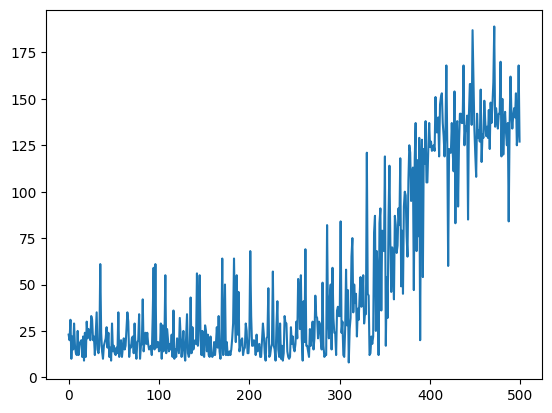

In [ ]:
plt.plot(results_dqn)
plt.show()

## PPO

## Part 2

Proximal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a type of policy gradient method. Instead of calculating Q-values, we train a network $\pi$ to optimize the probability of taking good actions directly, using states as inputs and actions as outputs. PPO also uses a value network $V$ that estimates state values in order to estimate the advantage $\hat{A}$.

Tuples of state, action distribution, action taken, and return $(s,\pi(s), a,\hat{R})$ are gathered for several rollouts. After training on this experience, these tuples are discarded and new experience is gathered.

Loss for the value network and the policy network are calculated according to the following formula:

$Loss=ValueLoss+PolicyLoss$

$ValueLoss=\frac{1}{N}\sum \bigg(\hat{R} - V(s) \bigg)^2 $

$PolicyLoss=-\frac{1}{N}\sum \min\bigg( \frac{\pi'(a|s)}{\pi(a|s)} \hat{A}, clip(\frac{\pi'(a|s)}{\pi(a|s)},1-\epsilon,1+\epsilon) \hat{A} \bigg) $

$\hat{R}_t = \sum_{i=t}^H \gamma^{i-t}r_i$

$\hat{A}_t=\hat{R}_t-V(s_t)$

Here, $\pi'(a|s)$ is the probability of taking an action given a state under the current policy and $\pi(a|s)$ is the probability of taking an action given a state under the policy used to gather data. In the loss function, $a$ is the action your agent actually took and is sampled from memory.

Additionally, the $clip$ function clips the value of the first argument according to the lower and upper bounds in the second and third arguments resectively.

Another important note: Your the calculation of your advantage $\hat{A}$ should not permit gradient flow from your policy loss calculation. In other words, make sure to call `.detach()` on your advantage.

### TODO

- Implement calculate return method
- Implement get action method
- Implement PPO learning algorithm

In [ ]:
from math import pi
def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  """
  the_return = 0
  for i in range(len(rollout)-1, -1, -1):
    state, action, action_dist, reward = rollout[i]
    the_return = reward + gamma*the_return  # Compute discounted return
    memory.append((state, action, action_dist.detach(), the_return))  # Append updated tuple

  return memory


def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network

    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """
  state = torch.from_numpy(state).float().unsqueeze(0).to(device)
  action_dist = network(state)    # Get action distribution from policy network
  action = torch.multinomial(action_dist, 1).item()   # Sample action from distribtuion
  return action, action_dist


def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
  """Implement PPO policy and value network updates. Iterate over your entire
     memory the number of times indicated by policy_epochs.

    Args:
        optim (Adam): value and policy optimizer
        policy (PolicyNetwork): Policy Network
        value (ValueNetwork): Value Network
        memory_dataloader (DataLoader): dataloader with (state, action, action_dist, return) tensors
        epsilon (float): trust region
        policy_epochs (int): number of times to iterate over all memory
  """

  for epoch in range(policy_epochs):
      for batch in memory_dataloader:

          # Calculate value loss
          state, action, action_dist, returns = batch
          state = state.to(device)
          action = action.to(device)
          action_dist = action_dist.view(-1, action_dist.shape[-1]).to(device)
          returns = returns.to(device)

          V = value(state)
          value_loss = torch.mean(torch.pow(returns - V, 2))

          # Calculate policy loss
          A = (returns - V).detach()
          pi_prime = policy(state).to(device)

          # pi_prime has shape (batch_size, action_size) after this line
          pi_prime_action = torch.gather(pi_prime, 1, action.unsqueeze(1)).squeeze(1)
          pi_action = torch.gather(action_dist, 1, action.unsqueeze(1)).squeeze(1)
          pi_ratio = pi_prime_action / pi_action
          policy_loss = -torch.mean(torch.min(pi_ratio*A, torch.clamp(pi_ratio, 1-epsilon, 1+epsilon)*A))

          # Calculate total loss and perform optimization step
          loss = value_loss + policy_loss
          optim.zero_grad()
          loss.backward()
          optim.step()

### Modules

In [ ]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))

  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    return self.net(x)


# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))

  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

### Main

In [ ]:
def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 20
  env_samples = 100
  gamma = 0.9
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  policy_network = PolicyNetwork(state_size, action_size).cuda()
  value_network = ValueNetwork(state_size).cuda()

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # Record only last epoch
    if last_epoch:
      env = wrap_env(env)

    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):

      # Reset environment
      state, _ = env.reset()
      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward

      # Begin episode
      while not done and cum_reward < 200:  # End after 200 steps
        # Get action
        action, action_dist = get_action_ppo(policy_network, state)

        # Take step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
      env.close()
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)

    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)
    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo

results_ppo = ppo_main()
show_video()

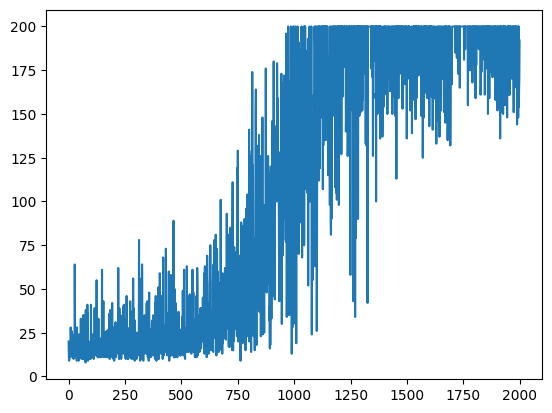

In [ ]:
plt.plot(results_ppo)
plt.show()